# MCMC Validation of Occultation Probabilities
## Phase 2: Ariel Mission Target Selection Analysis

This notebook performs Bayesian parameter estimation using Markov Chain Monte Carlo (MCMC) to validate and quantify uncertainties in occultation probability calculations for exoplanet targets.

### Methodology
- **Sampler:** emcee (affine-invariant ensemble sampler)
- **Parameters:** Stellar radius (R★) and planetary radius (R♃)
- **Priors:** Gaussian distributions centered on observed values
- **Physics:** Winn (2014) occultation probability formula
- **Dataset:** 3,946 exoplanets from Ariel Mission Candidate Sample

### Outputs
- Posterior distributions for 768 known planets and up to 3,178 target candidates
- Uncertainty quantification (16th, 50th, 84th percentiles)
- Data quality flags based on convergence and reliability
- Publication-ready visualizations

## Section 1: Imports & Setup

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from typing import Dict, Tuple, Optional, List
import multiprocessing as mp
from functools import partial

# MCMC and visualization
import emcee
import corner

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

# Define project paths (relative to notebook location)
notebook_path = Path.cwd()
project_root = notebook_path.parent.parent
data_path = project_root / "data" / "raw"
results_path = project_root / "analysis" / "results"

# Data files
known_planets_file = data_path / "Ariel_MCS_Known_2023-05-01.csv"
tpc_file = data_path / "Ariel_MCS_TPCs_2023-05-01.csv"
occultation_results_known = results_path / "known_planets_occultation_probability.csv"
occultation_results_tpc = results_path / "tpc_occultation_probability.csv"

print(f"\nProject paths:")
print(f"  Data: {data_path}")
print(f"  Results: {results_path}")
print(f"  Known planets file exists: {known_planets_file.exists()}")
print(f"  TPC file exists: {tpc_file.exists()}")
print(f"  Occultation results (known) exists: {occultation_results_known.exists()}")
print(f"  Occultation results (TPC) exists: {occultation_results_tpc.exists()}")

# Physical constants (IAU 2015 values)
AU_TO_METERS = 1.496e11  # 1 AU in meters
R_SUN_AU = 0.00465047    # Solar radius in AU
R_JUP_AU = 0.000477894   # Jupiter radius in AU
G_MS = 2.959122082e-4    # G*M_sun in AU^3/day^2 for circular orbit period

print(f"\n✓ Setup complete - Ready for MCMC validation")

✓ All libraries imported successfully

Project paths:
  Data: /Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/data/raw
  Results: /Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/analysis/results
  Known planets file exists: True
  TPC file exists: True
  Occultation results (known) exists: True
  Occultation results (TPC) exists: True

✓ Setup complete - Ready for MCMC validation


In [2]:
# Load data files
print("Loading data files...")

# Load original MCS data with uncertainties
df_known_raw = pd.read_csv(known_planets_file)
df_tpc_raw = pd.read_csv(tpc_file)

# Load Phase 1 results (occultation probabilities already calculated)
df_known_results = pd.read_csv(occultation_results_known)
df_tpc_results = pd.read_csv(occultation_results_tpc)

print(f"\n✓ Data loaded:")
print(f"  Known planets: {len(df_known_raw)} systems")
print(f"  TPCs: {len(df_tpc_raw)} candidates")
print(f"  Known planets with occultation results: {len(df_known_results)}")
print(f"  TPCs with occultation results: {len(df_tpc_results)}")

# Merge data: combine original with Phase 1 results
df_known = df_known_raw.copy()
df_tpc = df_tpc_raw.copy()

# Add occultation probability from Phase 1
if 'Occultation_Probability' in df_known_results.columns:
    known_merge_cols = ['Planet Name', 'Occultation_Probability']
    if all(col in df_known_results.columns for col in known_merge_cols):
        df_known = df_known.merge(
            df_known_results[known_merge_cols],
            on='Planet Name',
            how='left'
        )
        print(f"\n✓ Merged Phase 1 results with known planets")

if 'Occultation_Probability' in df_tpc_results.columns:
    tpc_merge_cols = ['Planet Name', 'Occultation_Probability']
    if all(col in df_tpc_results.columns for col in tpc_merge_cols):
        df_tpc = df_tpc.merge(
            df_tpc_results[tpc_merge_cols],
            on='Planet Name',
            how='left'
        )
        print(f"✓ Merged Phase 1 results with TPC candidates")

print(f"\n✓ Data merge complete")

Loading data files...

✓ Data loaded:
  Known planets: 768 systems
  TPCs: 3178 candidates
  Known planets with occultation results: 768
  TPCs with occultation results: 3178

✓ Merged Phase 1 results with known planets
✓ Merged Phase 1 results with TPC candidates

✓ Data merge complete


In [3]:
# Function to handle missing uncertainties
def get_uncertainty_or_default(value: float, error: Optional[float], default_fraction: float = 0.05) -> float:
    """
    Return provided error or default percentage of value.
    
    Parameters
    ----------
    value : float
        The measured value
    error : Optional[float]
        The provided uncertainty (can be NaN)
    default_fraction : float
        Default error as fraction of value (default 5%)
        
    Returns
    -------
    float
        The uncertainty to use (minimum 1% of value)
    """
    if pd.isna(error) or error <= 0:
        uncertainty = value * default_fraction
    else:
        uncertainty = error
    
    # Ensure minimum uncertainty
    return max(uncertainty, value * 0.01)

# Process uncertainties for known planets
print("\nProcessing uncertainties for known planets...")

for col in ['Star Radius [Rs]', 'Planet Radius [Rj]']:
    error_col_lower = col.replace('[', 'Error Lower [').replace(']', ']')
    error_col_upper = col.replace('[', 'Error Upper [').replace(']', ']')
    error_col = col.replace('[', '_error_[')
    
    if col not in df_known.columns:
        continue
    
    # Use average of lower/upper errors, or default
    if error_col_lower in df_known.columns and error_col_upper in df_known.columns:
        df_known[error_col] = df_known.apply(
            lambda row: get_uncertainty_or_default(
                row[col],
                (abs(row[error_col_lower]) + abs(row[error_col_upper])) / 2
            ),
            axis=1
        )
    else:
        df_known[error_col] = df_known[col].apply(
            lambda x: get_uncertainty_or_default(x, None)
        )

# Process uncertainties for TPCs (often minimal data)
print("Processing uncertainties for TPCs...")
for col in ['Star Radius [Rs]', 'Planet Radius [Rj]']:
    error_col = col.replace('[', '_error_[')
    if col not in df_tpc.columns:
        continue
    
    df_tpc[error_col] = df_tpc[col].apply(
        lambda x: get_uncertainty_or_default(x, None, default_fraction=0.10)  # Use 10% for TPC
    )

print("✓ Uncertainties processed (missing values filled with defaults)")
print(f"  Known planets: {len(df_known)} rows with error columns")
print(f"  TPCs: {len(df_tpc)} rows with error columns")


Processing uncertainties for known planets...
Processing uncertainties for TPCs...
✓ Uncertainties processed (missing values filled with defaults)
  Known planets: 768 rows with error columns
  TPCs: 3178 rows with error columns


## Section 2: Define Occultation Probability Function

In [4]:
def semi_major_axis_from_period(period_days: float, stellar_mass_msun: float) -> float:
    """
    Calculate semi-major axis from orbital period using Kepler's Third Law.
    
    Formula: a³ = (G*M_sun*P²)/(4π²)
    
    Parameters
    ----------
    period_days : float
        Orbital period in days
    stellar_mass_msun : float
        Stellar mass in solar masses
        
    Returns
    -------
    float
        Semi-major axis in AU
    """
    if pd.isna(period_days) or pd.isna(stellar_mass_msun) or period_days <= 0 or stellar_mass_msun <= 0:
        return np.nan
    
    a_cubed = (G_MS * stellar_mass_msun * period_days**2) / (4 * np.pi**2)
    return np.power(a_cubed, 1/3)


def calculate_transit_depth(
    planet_radius_rj: float,
    stellar_radius_rs: float
) -> float:
    """
    Calculate transit depth (geometric).
    
    Transit depth = (R_planet / R_star)²
    
    This is the fractional decrease in stellar flux when the planet
    transits in front of the star.
    
    Parameters
    ----------
    planet_radius_rj : float
        Planetary radius in Jupiter radii
    stellar_radius_rs : float
        Stellar radius in solar radii
        
    Returns
    -------
    float
        Transit depth (dimensionless ratio)
    """
    if pd.isna(planet_radius_rj) or pd.isna(stellar_radius_rs):
        return np.nan
    
    if planet_radius_rj <= 0 or stellar_radius_rs <= 0:
        return np.nan
    
    # Convert to same units (solar radii)
    # 1 R_jup = 0.10045 R_sun
    R_JUP_TO_R_SUN = 0.10045
    planet_radius_rs_units = planet_radius_rj * R_JUP_TO_R_SUN
    
    # Transit depth
    depth = (planet_radius_rs_units / stellar_radius_rs)**2
    
    return depth


def calculate_eclipse_depth(
    planet_radius_rj: float,
    stellar_radius_rs: float,
    planet_temp_k: float,
    stellar_temp_k: float
) -> float:
    """
    Calculate secondary eclipse depth (thermal emission, bolometric).
    
    Formula: δ_eclipse = (R_p/R_*)² × (T_p/T_*)⁴
    
    This is the Stefan-Boltzmann integrated thermal emission ratio.
    Valid for infrared wavelengths where thermal emission dominates.
    
    Parameters
    ----------
    planet_radius_rj : float
        Planetary radius in Jupiter radii
    stellar_radius_rs : float
        Stellar radius in solar radii
    planet_temp_k : float
        Planet dayside equilibrium temperature (K)
    stellar_temp_k : float
        Stellar effective temperature (K)
        
    Returns
    -------
    float
        Eclipse depth (dimensionless, e.g., 0.000085 = 85 ppm)
        
    References
    ----------
    - Seager & Deming (2010), ARA&A
    - Knutson et al. (2008), ApJ (HD 189733b eclipse)
    """
    # Validate inputs
    if any(pd.isna(x) for x in [planet_radius_rj, stellar_radius_rs, 
                                  planet_temp_k, stellar_temp_k]):
        return np.nan
    
    if any(x <= 0 for x in [planet_radius_rj, stellar_radius_rs, 
                             planet_temp_k, stellar_temp_k]):
        return np.nan
    
    # Convert radii to same units (solar radii)
    R_JUP_TO_R_SUN = 0.10045  # R_Jup / R_Sun
    planet_radius_rs = planet_radius_rj * R_JUP_TO_R_SUN
    
    # Geometric factor: (R_p / R_*)²
    geometric_factor = (planet_radius_rs / stellar_radius_rs)**2
    
    # Thermal emission ratio: (T_p / T_*)⁴ (Stefan-Boltzmann)
    temp_ratio = (planet_temp_k / stellar_temp_k)**4
    
    # Eclipse depth (bolometric)
    eclipse_depth = geometric_factor * temp_ratio
    
    return eclipse_depth


def estimate_planet_temperature(
    stellar_temp_k: float,
    stellar_radius_rs: float,
    semi_major_axis_au: float,
    albedo: float = 0.0,
    f_redistribute: float = 0.5
) -> float:
    """
    Estimate planet equilibrium temperature using energy balance.
    
    T_eq = T_* × sqrt(R_*/2a) × [(1-A)/f]^(1/4)
    
    Parameters
    ----------
    stellar_temp_k : float
        Stellar effective temperature in Kelvin
    stellar_radius_rs : float
        Stellar radius in solar radii
    semi_major_axis_au : float
        Semi-major axis in AU
    albedo : float
        Bond albedo (default 0 for hot Jupiters)
    f_redistribute : float
        Heat redistribution efficiency: 0.5 for day-night, 0.25 for full redistribution
        
    Returns
    -------
    float
        Equilibrium temperature in Kelvin
    """
    if any(pd.isna(x) for x in [stellar_temp_k, stellar_radius_rs, semi_major_axis_au]):
        return np.nan
    
    if any(x <= 0 for x in [stellar_temp_k, stellar_radius_rs, semi_major_axis_au]):
        return np.nan
    
    # Convert stellar radius to AU
    stellar_radius_au = stellar_radius_rs * R_SUN_AU
    
    # Equilibrium temperature formula
    t_eq = stellar_temp_k * np.sqrt(stellar_radius_au / (2 * semi_major_axis_au))
    t_eq *= ((1 - albedo) / f_redistribute)**0.25
    
    return t_eq


def calculate_occultation_probability(
    stellar_radius_rs: float,
    planet_radius_rj: float,
    semi_major_axis_au: float,
    eccentricity: float = 0.0,
    argument_periastron_deg: float = 0.0
) -> float:
    """
    Calculate occultation probability using Winn (2014) formula.
    
    For circular orbits (e=0):
        P_occ = (R_star + R_planet) / a
    
    For eccentric orbits:
        P_occ = (R_star + R_planet) / a * (1 + e*sin(ω)) / (1 - e²)
    
    Parameters
    ----------
    stellar_radius_rs : float
        Stellar radius in solar radii
    planet_radius_rj : float
        Planetary radius in Jupiter radii
    semi_major_axis_au : float
        Semi-major axis in AU
    eccentricity : float
        Orbital eccentricity (default 0)
    argument_periastron_deg : float
        Argument of periastron in degrees (default 0)
        
    Returns
    -------
    float
        Occultation probability, clipped to [0, 1]
    """
    # Validate inputs
    if any(pd.isna(x) for x in [stellar_radius_rs, planet_radius_rj, semi_major_axis_au]):
        return np.nan
    
    if any(x <= 0 for x in [stellar_radius_rs, planet_radius_rj, semi_major_axis_au]):
        return np.nan
    
    # Ensure valid eccentricity
    eccentricity = max(0.0, min(eccentricity, 0.9999))
    
    # Convert radii to AU
    r_star_au = stellar_radius_rs * R_SUN_AU
    r_planet_au = planet_radius_rj * R_JUP_AU
    
    # Base probability
    p_base = (r_star_au + r_planet_au) / semi_major_axis_au
    
    # Apply eccentricity correction
    if eccentricity > 1e-6:
        omega_rad = np.radians(argument_periastron_deg)
        eccentric_factor = (1 + eccentricity * np.sin(omega_rad)) / (1 - eccentricity**2)
        p_occ = p_base * eccentric_factor
    else:
        p_occ = p_base
    
    # Clip to valid range
    return np.clip(p_occ, 0.0, 1.0)


# Test functions
print("Testing functions...")
test_pocc = calculate_occultation_probability(
    stellar_radius_rs=1.155,
    planet_radius_rj=1.359,
    semi_major_axis_au=0.04707,
    eccentricity=0.0
)
test_transit = calculate_transit_depth(
    planet_radius_rj=1.359,
    stellar_radius_rs=1.155
)
test_temp = estimate_planet_temperature(
    stellar_temp_k=6065,
    stellar_radius_rs=1.155,
    semi_major_axis_au=0.04707,
    albedo=0.0,
    f_redistribute=0.5
)
test_eclipse = calculate_eclipse_depth(
    planet_radius_rj=1.359,
    stellar_radius_rs=1.155,
    planet_temp_k=test_temp,
    stellar_temp_k=6065
)
print(f"Test (HD 209458b):")
print(f"  P_occ = {test_pocc:.6f} (expected ~0.128)")
print(f"  Transit depth = {test_transit:.6e} (= {test_transit*1e6:.1f} ppm)")
print(f"  T_eq = {test_temp:.0f} K")
print(f"  Eclipse depth (bolometric) = {test_eclipse:.6e} (= {test_eclipse*1e6:.1f} ppm)")
print("✓ Functions defined")

Testing functions...
Test (HD 209458b):
  P_occ = 0.127911 (expected ~0.128)
  Transit depth = 1.396931e-02 (= 13969.3 ppm)
  T_eq = 1723 K
  Eclipse depth (bolometric) = 9.095239e-05 (= 91.0 ppm)
✓ Functions defined


## Section 3: MCMC Log-Probability Function

In [5]:
def log_probability(
    parameters: np.ndarray,
    observed_stellar_radius: float,
    stellar_radius_error: float,
    observed_planet_radius: float,
    planet_radius_error: float
) -> float:
    """
    Calculate log-probability for Gaussian priors on stellar and planetary radii.
    
    Prior: Gaussian centered on observed values with given uncertainties.
    
    Parameters
    ----------
    parameters : np.ndarray
        [stellar_radius_rs, planet_radius_rj]
    observed_stellar_radius : float
        Measured stellar radius in R_sun
    stellar_radius_error : float
        Uncertainty in stellar radius
    observed_planet_radius : float
        Measured planet radius in R_jup
    planet_radius_error : float
        Uncertainty in planet radius
        
    Returns
    -------
    float
        Log-probability (log-prior for Gaussian priors)
    """
    stellar_radius_mcmc, planet_radius_mcmc = parameters
    
    # Reject non-physical values
    if stellar_radius_mcmc <= 0 or planet_radius_mcmc <= 0:
        return -np.inf
    
    if any(pd.isna(x) for x in parameters):
        return -np.inf
    
    # Gaussian priors
    log_prob_star = -0.5 * ((stellar_radius_mcmc - observed_stellar_radius) / stellar_radius_error)**2
    log_prob_planet = -0.5 * ((planet_radius_mcmc - observed_planet_radius) / planet_radius_error)**2
    
    log_prob_total = log_prob_star + log_prob_planet
    
    return log_prob_total


def log_probability_wrapper(
    parameters: np.ndarray,
    planet_data: pd.Series
) -> float:
    """
    Wrapper function to prepare data for log_probability function.
    
    Parameters
    ----------
    parameters : np.ndarray
        [stellar_radius_rs, planet_radius_rj]
    planet_data : pd.Series
        Row from DataFrame with planetary parameters
        
    Returns
    -------
    float
        Log-probability
    """
    try:
        obs_stellar_rad = planet_data['Star Radius [Rs]']
        
        # Get stellar radius error - try multiple column names
        if 'Star Radius Error Lower [Rs]' in planet_data.index and 'Star Radius Error Upper [Rs]' in planet_data.index:
            err_stellar_rad = (abs(planet_data['Star Radius Error Lower [Rs]']) + abs(planet_data['Star Radius Error Upper [Rs]'])) / 2
        elif 'Star Radius_error_[Rs]' in planet_data.index:
            err_stellar_rad = planet_data['Star Radius_error_[Rs]']
        else:
            err_stellar_rad = obs_stellar_rad * 0.05
        
        obs_planet_rad = planet_data['Planet Radius [Rj]']
        
        # Get planet radius error - try multiple column names
        if 'Planet Radius Error Lower [Rj]' in planet_data.index and 'Planet Radius Error Upper [Rj]' in planet_data.index:
            err_planet_rad = (abs(planet_data['Planet Radius Error Lower [Rj]']) + abs(planet_data['Planet Radius Error Upper [Rj]'])) / 2
        elif 'Planet Radius_error_[Rj]' in planet_data.index:
            err_planet_rad = planet_data['Planet Radius_error_[Rj]']
        else:
            err_planet_rad = obs_planet_rad * 0.05
        
        if any(pd.isna(x) for x in [obs_stellar_rad, err_stellar_rad, obs_planet_rad, err_planet_rad]):
            return -np.inf
        
        return log_probability(
            parameters,
            obs_stellar_rad,
            err_stellar_rad,
            obs_planet_rad,
            err_planet_rad
        )
    except (KeyError, TypeError):
        return -np.inf


print("✓ Log-probability function defined")

✓ Log-probability function defined


## Section 4: MCMC Runner Function

In [6]:
def run_mcmc_single_planet(
    planet_data: pd.Series,
    nwalkers: int = 16,
    nsteps: int = 2000,
    burn_in: int = 500
) -> Dict[str, float]:
    """
    Run MCMC validation for a single planet and calculate occultation probability posteriors.
    
    Parameters
    ----------
    planet_data : pd.Series
        DataFrame row with planet parameters
    nwalkers : int
        Number of MCMC walkers (default 16)
    nsteps : int
        Number of MCMC steps (default 2000)
    burn_in : int
        Number of burn-in steps to discard (default 500)
        
    Returns
    -------
    Dict[str, float]
        Dictionary with:
        - 'Pocc_median': Median occultation probability
        - 'Pocc_16': 16th percentile (lower bound)
        - 'Pocc_84': 84th percentile (upper bound)
        - 'Transit_depth_median': Median transit depth
        - 'Transit_depth_16': 16th percentile (lower bound)
        - 'Transit_depth_84': 84th percentile (upper bound)
        - 'Transit_depth_ppm': Transit depth in parts per million
        - 'Transit_depth_source': Source of transit depth ('dataset' or 'calculated')
        - 'Eclipse_depth_median': Median eclipse depth (bolometric)
        - 'Eclipse_depth_16': 16th percentile (lower bound)
        - 'Eclipse_depth_84': 84th percentile (upper bound)
        - 'Eclipse_depth_ppm': Eclipse depth in parts per million
        - 'Planet_temp_median': Median equilibrium temperature (K)
        - 'Planet_temp_source': Source of temperature ('dataset' or 'calculated')
        - 'TSM_median': Median Transmission Spectroscopy Metric
        - 'TSM_16': 16th percentile TSM
        - 'TSM_84': 84th percentile TSM
        - 'ESM_median': Median Emission Spectroscopy Metric
        - 'ESM_16': 16th percentile ESM
        - 'ESM_84': 84th percentile ESM
        - 'reliability': Data quality score (1 - (upper - lower) / median)
        - 'converged': Boolean flag for successful convergence
        - 'autocorr_time': Estimated autocorrelation time (if available)
    """
    results = {
        'Pocc_median': np.nan,
        'Pocc_16': np.nan,
        'Pocc_84': np.nan,
        'Transit_depth_median': np.nan,
        'Transit_depth_16': np.nan,
        'Transit_depth_84': np.nan,
        'Transit_depth_ppm': np.nan,
        'Transit_depth_source': 'none',
        'Eclipse_depth_median': np.nan,
        'Eclipse_depth_16': np.nan,
        'Eclipse_depth_84': np.nan,
        'Eclipse_depth_ppm': np.nan,
        'Planet_temp_median': np.nan,
        'Planet_temp_source': 'none',
        'TSM_median': np.nan,
        'TSM_16': np.nan,
        'TSM_84': np.nan,
        'ESM_median': np.nan,
        'ESM_16': np.nan,
        'ESM_84': np.nan,
        'reliability': np.nan,
        'converged': False,
        'autocorr_time': np.nan
    }
    
    try:
        # Validate required columns
        required_cols = ['Star Radius [Rs]', 'Planet Radius [Rj]',
                         'Planet Semi-major Axis [AU]']
        
        missing_cols = [col for col in required_cols if col not in planet_data.index]
        if missing_cols:
            return results
        
        # Extract orbital parameters
        semi_major_axis = planet_data['Planet Semi-major Axis [AU]']
        eccentricity = planet_data.get('Eccentricity', 0.0)
        periastron = planet_data.get('Periastron', 0.0)
        stellar_temp = planet_data.get('Star Temperature [K]', 5778.0)  # Default to solar
        
        # Extract data for TSM/ESM calculations from dataset
        planet_mass_mj = planet_data.get('Planet Mass [Mj]', np.nan)
        star_k_mag = planet_data.get('Star K Mag', np.nan)
        
        # Check if Planet Temperature is available in dataset
        planet_temp_dataset = planet_data.get('Planet Temperature [K]', np.nan)
        use_dataset_temp = pd.notna(planet_temp_dataset) and planet_temp_dataset > 0
        
        if use_dataset_temp:
            planet_temp_fixed = planet_temp_dataset
            temp_source = 'dataset'
        else:
            planet_temp_fixed = None
            temp_source = 'calculated'
        
        # Check if Transit Depth is available in dataset (convert from % to fraction)
        transit_depth_dataset = planet_data.get('Transit Depth [%]', np.nan)
        use_dataset_transit = pd.notna(transit_depth_dataset) and transit_depth_dataset > 0
        
        if use_dataset_transit:
            # Convert from percentage to fraction
            transit_depth_fixed = transit_depth_dataset / 100.0
            
            # Get transit depth errors (also convert from % to fraction)
            transit_depth_err_upper = planet_data.get('Transit Depth Error Upper [%]', 0)
            transit_depth_err_lower = planet_data.get('Transit Depth Error Lower [%]', 0)
            if pd.notna(transit_depth_err_upper) and pd.notna(transit_depth_err_lower):
                transit_depth_err = (abs(transit_depth_err_upper) + abs(transit_depth_err_lower)) / 2 / 100.0
            else:
                transit_depth_err = transit_depth_fixed * 0.05  # 5% default
            
            transit_source = 'dataset'
        else:
            transit_depth_fixed = None
            transit_depth_err = None
            transit_source = 'calculated'
        
        # Handle missing orbital parameters
        if pd.isna(semi_major_axis):
            return results
        if pd.isna(eccentricity):
            eccentricity = 0.0
        if pd.isna(periastron):
            periastron = 0.0
        if pd.isna(stellar_temp):
            stellar_temp = 5778.0
        
        # Initialize walker positions (Gaussian around observed values)
        obs_stellar_rad = planet_data['Star Radius [Rs]']
        
        # Get stellar radius error - try multiple column names
        if 'Star Radius Error Lower [Rs]' in planet_data.index and 'Star Radius Error Upper [Rs]' in planet_data.index:
            err_stellar_rad = (abs(planet_data['Star Radius Error Lower [Rs]']) + abs(planet_data['Star Radius Error Upper [Rs]'])) / 2
        elif 'Star Radius_error_[Rs]' in planet_data.index:
            err_stellar_rad = planet_data['Star Radius_error_[Rs]']
        else:
            err_stellar_rad = obs_stellar_rad * 0.05
        
        obs_planet_rad = planet_data['Planet Radius [Rj]']
        
        # Get planet radius error - try multiple column names
        if 'Planet Radius Error Lower [Rj]' in planet_data.index and 'Planet Radius Error Upper [Rj]' in planet_data.index:
            err_planet_rad = (abs(planet_data['Planet Radius Error Lower [Rj]']) + abs(planet_data['Planet Radius Error Upper [Rj]'])) / 2
        elif 'Planet Radius_error_[Rj]' in planet_data.index:
            err_planet_rad = planet_data['Planet Radius_error_[Rj]']
        else:
            err_planet_rad = obs_planet_rad * 0.05
        
        # Ensure positive errors
        err_stellar_rad = max(err_stellar_rad, obs_stellar_rad * 0.01)
        err_planet_rad = max(err_planet_rad, obs_planet_rad * 0.01)
        
        # Initial positions for walkers
        p0 = np.random.normal(
            loc=[obs_stellar_rad, obs_planet_rad],
            scale=[err_stellar_rad, err_planet_rad],
            size=(nwalkers, 2)
        )
        
        # Ensure positive radii
        p0 = np.abs(p0)
        
        # Create sampler
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim=2,
            log_prob_fn=log_probability_wrapper,
            args=(planet_data,)
        )
        
        # Run MCMC
        sampler.run_mcmc(p0, nsteps, progress=False)
        
        # Extract samples after burn-in
        samples = sampler.get_chain(discard=burn_in, flat=True)
        
        if len(samples) < 10:
            return results
        
        # Calculate derived quantities for each posterior sample
        occultation_samples = []
        transit_depth_samples = []
        eclipse_depth_samples = []
        planet_temp_samples = []
        tsm_samples = []
        esm_samples = []
        
        for sample in samples:
            stellar_rad_sample, planet_rad_sample = sample
            
            # Occultation probability
            p_occ_sample = calculate_occultation_probability(
                stellar_radius_rs=stellar_rad_sample,
                planet_radius_rj=planet_rad_sample,
                semi_major_axis_au=semi_major_axis,
                eccentricity=eccentricity,
                argument_periastron_deg=periastron
            )
            if not np.isnan(p_occ_sample):
                occultation_samples.append(p_occ_sample)
            
            # Transit depth: use dataset value if available, otherwise calculate
            if use_dataset_transit:
                # Sample from Gaussian distribution around measured value
                transit_depth_sample = np.random.normal(transit_depth_fixed, transit_depth_err)
                transit_depth_sample = max(0, transit_depth_sample)  # Ensure non-negative
            else:
                transit_depth_sample = calculate_transit_depth(
                    planet_radius_rj=planet_rad_sample,
                    stellar_radius_rs=stellar_rad_sample
                )
            
            if not np.isnan(transit_depth_sample) and transit_depth_sample > 0:
                transit_depth_samples.append(transit_depth_sample)
            
            # Planet temperature: use dataset value if available, otherwise calculate
            if use_dataset_temp:
                planet_temp_sample = planet_temp_fixed
            else:
                planet_temp_sample = estimate_planet_temperature(
                    stellar_temp_k=stellar_temp,
                    stellar_radius_rs=stellar_rad_sample,
                    semi_major_axis_au=semi_major_axis,
                    albedo=0.0,
                    f_redistribute=0.5
                )
            
            if not np.isnan(planet_temp_sample):
                planet_temp_samples.append(planet_temp_sample)
                
                # Eclipse depth: use transit depth from dataset if available
                # Eclipse depth = Transit depth × (T_planet / T_star)^4
                if use_dataset_transit and transit_depth_sample > 0:
                    # Use measured transit depth with temperature ratio
                    temp_ratio = (planet_temp_sample / stellar_temp)**4
                    eclipse_depth_sample = transit_depth_sample * temp_ratio
                else:
                    # Fall back to full calculation from radii
                    eclipse_depth_sample = calculate_eclipse_depth(
                        planet_radius_rj=planet_rad_sample,
                        stellar_radius_rs=stellar_rad_sample,
                        planet_temp_k=planet_temp_sample,
                        stellar_temp_k=stellar_temp
                    )
                
                if not np.isnan(eclipse_depth_sample) and eclipse_depth_sample > 0:
                    eclipse_depth_samples.append(eclipse_depth_sample)
            
            # ========== TRANSMISSION SPECTROSCOPY METRIC (TSM) ==========
            # TSM = (R_p^3 * T_eq) / (M_p * R_*^2) * 10^(-K_mag/5)
            # Kempton et al. (2018) PASP 130, 114401
            if pd.notna(planet_mass_mj) and pd.notna(star_k_mag) and planet_mass_mj > 0:
                scale_factor = 10**(-star_k_mag / 5.0)
                tsm_sample = ((planet_rad_sample**3) * planet_temp_sample) / (planet_mass_mj * (stellar_rad_sample**2)) * scale_factor
                if not np.isnan(tsm_sample) and tsm_sample > 0:
                    tsm_samples.append(tsm_sample)
            
            # ========== EMISSION SPECTROSCOPY METRIC (ESM) ==========
            # ESM = (T_p^4 * R_p^2) / (T_* * R_*^2) * 10^(-K_mag/5)
            # Kempton et al. (2018) PASP 130, 114401
            if pd.notna(stellar_temp) and pd.notna(star_k_mag) and stellar_temp > 0:
                scale_factor = 10**(-star_k_mag / 5.0)
                esm_sample = ((planet_temp_sample**4) * (planet_rad_sample**2)) / (stellar_temp * (stellar_rad_sample**2)) * scale_factor
                if not np.isnan(esm_sample) and esm_sample > 0:
                    esm_samples.append(esm_sample)
        
        if len(occultation_samples) < 5:
            return results
        
        occultation_samples = np.array(occultation_samples)
        transit_depth_samples = np.array(transit_depth_samples)
        eclipse_depth_samples = np.array(eclipse_depth_samples) if eclipse_depth_samples else np.array([np.nan])
        planet_temp_samples = np.array(planet_temp_samples) if planet_temp_samples else np.array([np.nan])
        tsm_samples = np.array(tsm_samples) if tsm_samples else np.array([np.nan])
        esm_samples = np.array(esm_samples) if esm_samples else np.array([np.nan])
        
        # Calculate posterior statistics for occultation probability
        pocc_median = np.median(occultation_samples)
        pocc_16 = np.percentile(occultation_samples, 16)
        pocc_84 = np.percentile(occultation_samples, 84)
        
        # Calculate posterior statistics for transit depth
        transit_depth_median = np.median(transit_depth_samples)
        transit_depth_16 = np.percentile(transit_depth_samples, 16)
        transit_depth_84 = np.percentile(transit_depth_samples, 84)
        transit_depth_ppm = transit_depth_median * 1e6
        
        # Calculate posterior statistics for eclipse depth
        if len(eclipse_depth_samples) > 0 and not np.all(np.isnan(eclipse_depth_samples)):
            eclipse_depth_median = np.nanmedian(eclipse_depth_samples)
            eclipse_depth_16 = np.nanpercentile(eclipse_depth_samples, 16)
            eclipse_depth_84 = np.nanpercentile(eclipse_depth_samples, 84)
            eclipse_depth_ppm = eclipse_depth_median * 1e6
        else:
            eclipse_depth_median = np.nan
            eclipse_depth_16 = np.nan
            eclipse_depth_84 = np.nan
            eclipse_depth_ppm = np.nan
        
        # Calculate planet temperature statistics
        if len(planet_temp_samples) > 0 and not np.all(np.isnan(planet_temp_samples)):
            planet_temp_median = np.nanmedian(planet_temp_samples)
        else:
            planet_temp_median = np.nan
        
        # Calculate TSM statistics
        if len(tsm_samples) > 0 and not np.all(np.isnan(tsm_samples)):
            tsm_median = np.nanmedian(tsm_samples)
            tsm_16 = np.nanpercentile(tsm_samples, 16)
            tsm_84 = np.nanpercentile(tsm_samples, 84)
        else:
            tsm_median = np.nan
            tsm_16 = np.nan
            tsm_84 = np.nan
        
        # Calculate ESM statistics
        if len(esm_samples) > 0 and not np.all(np.isnan(esm_samples)):
            esm_median = np.nanmedian(esm_samples)
            esm_16 = np.nanpercentile(esm_samples, 16)
            esm_84 = np.nanpercentile(esm_samples, 84)
        else:
            esm_median = np.nan
            esm_16 = np.nan
            esm_84 = np.nan
        
        # Calculate reliability score
        uncertainty_range = pocc_84 - pocc_16
        if pocc_median > 0.001:
            reliability = 1.0 - min(1.0, uncertainty_range / pocc_median)
        else:
            reliability = 0.0
        
        # Try to get autocorrelation time
        try:
            autocorr_time = np.mean(sampler.get_autocorr_time(quiet=True))
        except:
            autocorr_time = np.nan
        
        results = {
            'Pocc_median': float(pocc_median),
            'Pocc_16': float(pocc_16),
            'Pocc_84': float(pocc_84),
            'Transit_depth_median': float(transit_depth_median),
            'Transit_depth_16': float(transit_depth_16),
            'Transit_depth_84': float(transit_depth_84),
            'Transit_depth_ppm': float(transit_depth_ppm),
            'Transit_depth_source': transit_source,
            'Eclipse_depth_median': float(eclipse_depth_median) if not np.isnan(eclipse_depth_median) else np.nan,
            'Eclipse_depth_16': float(eclipse_depth_16) if not np.isnan(eclipse_depth_16) else np.nan,
            'Eclipse_depth_84': float(eclipse_depth_84) if not np.isnan(eclipse_depth_84) else np.nan,
            'Eclipse_depth_ppm': float(eclipse_depth_ppm) if not np.isnan(eclipse_depth_ppm) else np.nan,
            'Planet_temp_median': float(planet_temp_median) if not np.isnan(planet_temp_median) else np.nan,
            'Planet_temp_source': temp_source,
            'TSM_median': float(tsm_median) if not np.isnan(tsm_median) else np.nan,
            'TSM_16': float(tsm_16) if not np.isnan(tsm_16) else np.nan,
            'TSM_84': float(tsm_84) if not np.isnan(tsm_84) else np.nan,
            'ESM_median': float(esm_median) if not np.isnan(esm_median) else np.nan,
            'ESM_16': float(esm_16) if not np.isnan(esm_16) else np.nan,
            'ESM_84': float(esm_84) if not np.isnan(esm_84) else np.nan,
            'reliability': float(reliability),
            'converged': True,
            'autocorr_time': float(autocorr_time) if not np.isnan(autocorr_time) else np.nan
        }
        
    except Exception as e:
        # Silently handle MCMC failures
        pass
    
    return results


print("✓ MCMC runner function defined")

✓ MCMC runner function defined


## Section 5: Validate on Benchmark Planets

In [7]:
# Benchmark planets for validation
benchmark_planets = ['WASP-12 b', 'HD 189733 b', 'KELT-9 b', 'TOI-2109 b', 'WASP-121 b', 'HD 80606 b']

print("="*80)
print("BENCHMARK PLANET VALIDATION")
print("="*80)
print(f"\nRunning MCMC for {len(benchmark_planets)} benchmark planets...")
print("(Using reduced parameters for speed: 16 walkers, 2000 steps, 500 burn-in)")

benchmark_results = []

for planet_name in benchmark_planets:
    # Find planet in dataset
    planet_mask = df_known['Planet Name'].str.contains(planet_name.split()[0], case=False, na=False)
    
    if not planet_mask.any():
        print(f"  ⚠ {planet_name}: Not found in dataset")
        continue
    
    planet_row = df_known[planet_mask].iloc[0]
    
    print(f"\n  → {planet_name}")
    
    # Get stellar and planetary radii and uncertainties
    star_r = planet_row['Star Radius [Rs]']
    star_r_err_lower = planet_row.get('Star Radius Error Lower [Rs]', 0)
    star_r_err_upper = planet_row.get('Star Radius Error Upper [Rs]', 0)
    star_r_err = (abs(star_r_err_lower) + abs(star_r_err_upper)) / 2 if pd.notna(star_r_err_lower) else star_r * 0.05
    
    planet_r = planet_row['Planet Radius [Rj]']
    planet_r_err_lower = planet_row.get('Planet Radius Error Lower [Rj]', 0)
    planet_r_err_upper = planet_row.get('Planet Radius Error Upper [Rj]', 0)
    planet_r_err = (abs(planet_r_err_lower) + abs(planet_r_err_upper)) / 2 if pd.notna(planet_r_err_lower) else planet_r * 0.05
    
    # Check if temperature is available in dataset
    temp_in_dataset = planet_row.get('Planet Temperature [K]', np.nan)
    temp_source = "dataset" if pd.notna(temp_in_dataset) and temp_in_dataset > 0 else "calculated"
    
    # Check if transit depth is available in dataset
    transit_in_dataset = planet_row.get('Transit Depth [%]', np.nan)
    transit_source = "dataset" if pd.notna(transit_in_dataset) and transit_in_dataset > 0 else "calculated"
    
    print(f"    R★ = {star_r:.3f} ± {star_r_err:.3f} R☉")
    print(f"    R♃ = {planet_r:.3f} ± {planet_r_err:.3f} R♃")
    if temp_source == "dataset":
        print(f"    T_planet (dataset) = {temp_in_dataset:.0f} K")
    if transit_source == "dataset":
        print(f"    Transit depth (dataset) = {transit_in_dataset:.4f}% = {transit_in_dataset*1e4:.1f} ppm")
    
    # Run MCMC
    results = run_mcmc_single_planet(planet_row, nwalkers=16, nsteps=2000, burn_in=500)
    
    if results['converged']:
        print(f"    ✓ P_occ: {results['Pocc_median']:.4f} +{results['Pocc_84']-results['Pocc_median']:.4f} -{results['Pocc_median']-results['Pocc_16']:.4f}")
        print(f"    Transit depth: {results['Transit_depth_ppm']:.1f} ppm ({results['Transit_depth_source']})")
        print(f"    T_eq: {results['Planet_temp_median']:.0f} K ({results['Planet_temp_source']})")
        if not np.isnan(results['Eclipse_depth_ppm']):
            print(f"    Eclipse depth: {results['Eclipse_depth_ppm']:.1f} ppm (+{(results['Eclipse_depth_84']-results['Eclipse_depth_median'])*1e6:.1f} -{(results['Eclipse_depth_median']-results['Eclipse_depth_16'])*1e6:.1f})")
        if not np.isnan(results['TSM_median']):
            print(f"    TSM: {results['TSM_median']:.1f} (+{results['TSM_84']-results['TSM_median']:.1f} -{results['TSM_median']-results['TSM_16']:.1f})")
        if not np.isnan(results['ESM_median']):
            print(f"    ESM: {results['ESM_median']:.1f} (+{results['ESM_84']-results['ESM_median']:.1f} -{results['ESM_median']-results['ESM_16']:.1f})")
        print(f"    Reliability: {results['reliability']:.3f}")
    else:
        print(f"    ✗ MCMC did not converge")
    
    benchmark_results.append({
        'Planet Name': planet_name,
        'Star Name': planet_row['Star Name'],
        **results
    })

benchmark_df = pd.DataFrame(benchmark_results)

print("\n" + "="*80)
print("BENCHMARK RESULTS TABLE")
print("="*80)
display_cols = ['Planet Name', 'Pocc_median', 'Transit_depth_ppm', 'Transit_depth_source', 'Eclipse_depth_ppm', 'TSM_median', 'ESM_median', 'Planet_temp_source', 'reliability', 'converged']
available_cols = [col for col in display_cols if col in benchmark_df.columns]
print(benchmark_df[available_cols].to_string(index=False))

print("\n✓ Benchmark validation complete")

BENCHMARK PLANET VALIDATION

Running MCMC for 6 benchmark planets...
(Using reduced parameters for speed: 16 walkers, 2000 steps, 500 burn-in)

  → WASP-12 b
    R★ = 1.870 ± 0.110 R☉
    R♃ = 1.473 ± 0.096 R♃
    T_planet (dataset) = 1814 K
    Transit depth (dataset) = 0.6550% = 6550.0 ppm
    ✓ P_occ: 0.1789 +0.0093 -0.0098
    Transit depth: 6550.5 ppm (dataset)
    T_eq: 1814 K (dataset)
    Eclipse depth: 41.0 ppm (+1.0 -1.0)
    TSM: 3.6 (+0.8 -0.8)
    ESM: 10955459.2 (+1930146.1 -1816171.5)
    Reliability: 0.893

  → HD 189733 b
    R★ = 0.880 ± 0.010 R☉
    R♃ = 0.227 ± 0.006 R♃
    T_planet (dataset) = 748 K
    Transit depth (dataset) = 0.0705% = 705.0 ppm
    ✓ P_occ: 0.1789 +0.0093 -0.0098
    Transit depth: 6550.5 ppm (dataset)
    T_eq: 1814 K (dataset)
    Eclipse depth: 41.0 ppm (+1.0 -1.0)
    TSM: 3.6 (+0.8 -0.8)
    ESM: 10955459.2 (+1930146.1 -1816171.5)
    Reliability: 0.893

  → HD 189733 b
    R★ = 0.880 ± 0.010 R☉
    R♃ = 0.227 ± 0.006 R♃
    T_planet (data

## Section 6: Population MCMC with Parallel Processing

In [8]:
print("="*80)
print("KNOWN PLANETS: POPULATION MCMC ANALYSIS")
print("="*80)

# Filter dataset: only planets with reasonable occultation probabilities
print("\nFiltering known planets dataset...")

# Use known planets dataset for main population analysis
df_population = df_known.copy()

# Filter criteria
min_pocc = 0.05  # Minimum occultation probability

# Check if Occultation_Probability column exists
if 'Occultation_Probability' in df_population.columns:
    df_population = df_population[df_population['Occultation_Probability'] >= min_pocc].copy()
    print(f"Planets with P_occ >= {min_pocc}: {len(df_population)}")
else:
    print(f"Warning: 'Occultation_Probability' column not found. Using all {len(df_population)} planets.")

# Additional filtering: must have required parameters
required_for_mcmc = ['Star Radius [Rs]', 'Planet Radius [Rj]',
                     'Planet Semi-major Axis [AU]']
df_population = df_population.dropna(subset=required_for_mcmc)

print(f"Planets with complete parameters: {len(df_population)}")

# FULL DATASET ANALYSIS
# Process all planets with sufficient occultation probability
df_population_sample = df_population.copy()
print(f"\nProcessing FULL dataset: {len(df_population_sample)} planets")
print("Production settings for full analysis:")

# Production-quality settings (good balance of accuracy and speed)
nwalkers = 16
nsteps = 2000
burn_in = 500

print(f"  Walkers: {nwalkers}, Steps: {nsteps}, Burn-in: {burn_in}")

# Run MCMC sequentially with progress tracking
# (Sequential is more reliable in Jupyter notebooks on macOS than multiprocessing)
print("\nRunning MCMC sequentially with optimized settings...")

population_results = []

for idx, (_, planet_row) in enumerate(tqdm(df_population_sample.iterrows(), 
                                            total=len(df_population_sample),
                                            desc="MCMC Progress", 
                                            unit="planets")):
    try:
        result = run_mcmc_single_planet(planet_row, nwalkers=nwalkers, nsteps=nsteps, burn_in=burn_in)
        population_results.append(result)
    except Exception as e:
        # Append NaN result on failure
        population_results.append({
            'Pocc_median': np.nan,
            'Pocc_16': np.nan,
            'Pocc_84': np.nan,
            'reliability': np.nan,
            'converged': False,
            'autocorr_time': np.nan
        })

# Append benchmark results to ensure we have complete results
for _, row in benchmark_df.iterrows():
    population_results.append({
        'Pocc_median': row['Pocc_median'],
        'Pocc_16': row['Pocc_16'],
        'Pocc_84': row['Pocc_84'],
        'reliability': row['reliability'],
        'converged': row['converged'],
        'autocorr_time': np.nan
    })

# Create results DataFrame
results_df = df_population_sample.copy()
results_df = results_df.reset_index(drop=True)

# Add MCMC results to all population planets
for i, result in enumerate(population_results[:len(results_df)]):
    for key in ['Pocc_median', 'Pocc_16', 'Pocc_84', 
                'Transit_depth_median', 'Transit_depth_16', 'Transit_depth_84', 'Transit_depth_ppm', 'Transit_depth_source',
                'Eclipse_depth_median', 'Eclipse_depth_16', 'Eclipse_depth_84', 'Eclipse_depth_ppm',
                'Planet_temp_median', 'Planet_temp_source',
                'TSM_median', 'TSM_16', 'TSM_84',
                'ESM_median', 'ESM_16', 'ESM_84',
                'reliability', 'converged', 'autocorr_time']:
        if i < len(results_df):
            results_df.loc[i, key] = result.get(key, np.nan)

# Calculate uncertainty range
results_df['uncertainty_range'] = results_df['Pocc_84'] - results_df['Pocc_16']

print(f"\n✓ Known Planets MCMC analysis complete")
print(f"  Processed: {len(results_df)} planets")
print(f"  Converged: {results_df['converged'].sum()} systems")


# Store known planets results with specific name
results_df_known = results_df.copy()

KNOWN PLANETS: POPULATION MCMC ANALYSIS

Filtering known planets dataset...
Planets with P_occ >= 0.05: 621
Planets with complete parameters: 621

Processing FULL dataset: 621 planets
Production settings for full analysis:
  Walkers: 16, Steps: 2000, Burn-in: 500

Running MCMC sequentially with optimized settings...


MCMC Progress:   6%|▌         | 38/621 [00:22<05:55,  1.64planets/s]The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [29.97773186 41.47569233]
MCMC Progress: 100%|██████████| 621/621 [06:02<00:00,  1.71planets/s]



✓ Known Planets MCMC analysis complete
  Processed: 621 planets
  Converged: 611 systems


In [10]:
print("="*80)
print("TPC (TIER 1 CANDIDATES): POPULATION MCMC ANALYSIS")
print("="*80)

# Filter TPC dataset: only candidates with reasonable occultation probabilities
print("\nFiltering TPC dataset...")

# Use TPC dataset for candidate analysis
df_population_tpc = df_tpc.copy()

# Convert semi-major axis from meters to AU if needed (TPC file only has [m])
if 'Planet Semi-major Axis [m]' in df_population_tpc.columns and 'Planet Semi-major Axis [AU]' not in df_population_tpc.columns:
    print("Converting Planet Semi-major Axis from [m] to [AU]...")
    df_population_tpc['Planet Semi-major Axis [AU]'] = df_population_tpc['Planet Semi-major Axis [m]'] / AU_TO_METERS
    print(f"  Conversion complete: {df_population_tpc['Planet Semi-major Axis [AU]'].notna().sum()} TPCs with semi-major axis")

# Filter criteria
min_pocc = 0.05  # Minimum occultation probability

# Check if Occultation_Probability column exists
if 'Occultation_Probability' in df_population_tpc.columns:
    df_population_tpc = df_population_tpc[df_population_tpc['Occultation_Probability'] >= min_pocc].copy()
    print(f"TPCs with P_occ >= {min_pocc}: {len(df_population_tpc)}")
else:
    print(f"Warning: 'Occultation_Probability' column not found. Using all {len(df_population_tpc)} TPCs.")

# Additional filtering: must have required parameters
required_for_mcmc = ['Star Radius [Rs]', 'Planet Radius [Rj]',
                     'Planet Semi-major Axis [AU]']
df_population_tpc = df_population_tpc.dropna(subset=required_for_mcmc)

print(f"TPCs with complete parameters: {len(df_population_tpc)}")

# FULL TPC DATASET ANALYSIS
# Process all TPCs with sufficient occultation probability
df_population_sample_tpc = df_population_tpc.copy()
print(f"\nProcessing FULL TPC dataset: {len(df_population_sample_tpc)} candidates")
print("Production settings for full analysis:")

# Production-quality settings (good balance of accuracy and speed)
nwalkers = 16
nsteps = 2000
burn_in = 500

print(f"  Walkers: {nwalkers}, Steps: {nsteps}, Burn-in: {burn_in}")

# Run MCMC sequentially with progress tracking
print("\nRunning MCMC sequentially with optimized settings...")

population_results_tpc = []

for idx, (_, planet_row) in enumerate(tqdm(df_population_sample_tpc.iterrows(), 
                                            total=len(df_population_sample_tpc),
                                            desc="TPC MCMC Progress", 
                                            unit="candidates")):
    try:
        result = run_mcmc_single_planet(planet_row, nwalkers=nwalkers, nsteps=nsteps, burn_in=burn_in)
        population_results_tpc.append(result)
    except Exception as e:
        # Append NaN result on failure
        population_results_tpc.append({
            'Pocc_median': np.nan,
            'Pocc_16': np.nan,
            'Pocc_84': np.nan,
            'reliability': np.nan,
            'converged': False,
            'autocorr_time': np.nan
        })

# Create results DataFrame for TPCs
results_df_tpc = df_population_sample_tpc.copy()
results_df_tpc = results_df_tpc.reset_index(drop=True)

# Add MCMC results to all TPC candidates
for i, result in enumerate(population_results_tpc[:len(results_df_tpc)]):
    for key in ['Pocc_median', 'Pocc_16', 'Pocc_84', 
                'Transit_depth_median', 'Transit_depth_16', 'Transit_depth_84', 'Transit_depth_ppm', 'Transit_depth_source',
                'Eclipse_depth_median', 'Eclipse_depth_16', 'Eclipse_depth_84', 'Eclipse_depth_ppm',
                'Planet_temp_median', 'Planet_temp_source',
                'TSM_median', 'TSM_16', 'TSM_84',
                'ESM_median', 'ESM_16', 'ESM_84',
                'reliability', 'converged', 'autocorr_time']:
        if i < len(results_df_tpc):
            results_df_tpc.loc[i, key] = result.get(key, np.nan)

# Calculate uncertainty range
results_df_tpc['uncertainty_range'] = results_df_tpc['Pocc_84'] - results_df_tpc['Pocc_16']

print(f"\n✓ TPC MCMC analysis complete")
print(f"  Processed: {len(results_df_tpc)} candidates")
print(f"  Converged: {results_df_tpc['converged'].sum()} systems")

# Assign quality flags for TPCs
print("\nAssigning quality flags to TPC results...")

results_df_tpc['quality_flag'] = 'Unconverged'

# High quality: converged, high reliability
mask = (results_df_tpc['converged']) & (results_df_tpc['reliability'] > 0.8)
results_df_tpc.loc[mask, 'quality_flag'] = 'High'

# Medium quality: converged, moderate reliability
mask = (results_df_tpc['converged']) & (results_df_tpc['reliability'] > 0.5) & (results_df_tpc['reliability'] <= 0.8)
results_df_tpc.loc[mask, 'quality_flag'] = 'Medium'

# Low quality: converged, low reliability
mask = (results_df_tpc['converged']) & (results_df_tpc['reliability'] <= 0.5)
results_df_tpc.loc[mask, 'quality_flag'] = 'Low'

# Anomaly detection: converged but extreme uncertainty
mask = (results_df_tpc['converged']) & (results_df_tpc['uncertainty_range'] > 0.5)
results_df_tpc.loc[mask, 'quality_flag'] = 'Anomaly'

print(f"\n✓ TPC quality flags assigned")

TPC (TIER 1 CANDIDATES): POPULATION MCMC ANALYSIS

Filtering TPC dataset...
Converting Planet Semi-major Axis from [m] to [AU]...
  Conversion complete: 3178 TPCs with semi-major axis
TPCs with P_occ >= 0.05: 2810
TPCs with complete parameters: 2810

Processing FULL TPC dataset: 2810 candidates
Production settings for full analysis:
  Walkers: 16, Steps: 2000, Burn-in: 500

Running MCMC sequentially with optimized settings...


TPC MCMC Progress:   2%|▏         | 47/2810 [00:25<24:56,  1.85candidates/s]The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [30.06791997 43.99426216]
TPC MCMC Progress:   2%|▏         | 48/2810 [00:25<25:00,  1.84candidates/s]The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [30.06791997 43.99426216]
TPC MCMC Progress:  13%|█▎        | 359/2810 [03:17<22:32,  1.81candidates/s]The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [40.86102187 25.19068075]
TPC MCMC Progress:  13%|█▎        | 360/2810 [03:18<22:28,  1.82candidates/s]The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run 


✓ TPC MCMC analysis complete
  Processed: 2810 candidates
  Converged: 2810 systems

Assigning quality flags to TPC results...

✓ TPC quality flags assigned


## Section 7: Data Quality Flags

In [12]:
print("="*80)
print("KNOWN PLANETS: DATA QUALITY FLAGGING")
print("="*80)

# Use the known planets results
results_df = results_df_known.copy()

# Calculate uncertainty range for each planets
results_df['uncertainty_range'] = results_df['Pocc_84'] - results_df['Pocc_16']

# Define quality flags based on reliability
def assign_quality_flag(reliability: float, pocc_median: float, uncertainty_range: float) -> str:
    """
    Assign quality flag based on reliability and anomaly detection.
    
    Parameters
    ----------
    reliability : float
        Reliability score (0-1)
    pocc_median : float
        Median occultation probability
    uncertainty_range : float
        Range between 84th and 16th percentiles
        
    Returns
    -------
    str
        Quality flag: 'High', 'Medium', 'Low', or 'Anomaly'
    """
    # Check for anomalies
    if pd.isna(reliability) or pd.isna(pocc_median):
        return 'Unknown'
    
    # Anomaly flags: extreme probabilities or very large uncertainties
    if pocc_median > 0.95 or uncertainty_range > 0.3:
        return 'Anomaly'
    
    # Quality based on reliability
    if reliability > 0.8:
        return 'High'
    elif reliability > 0.5:
        return 'Medium'
    else:
        return 'Low'

results_df['quality_flag'] = results_df.apply(
    lambda row: assign_quality_flag(row['reliability'], row['Pocc_median'], row['uncertainty_range']),
    axis=1
)

# Flag convergence issues
results_df['quality_flag'] = results_df.apply(
    lambda row: 'Unconverged' if not row['converged'] else row['quality_flag'],
    axis=1
)

# Print summary statistics
print("\nQuality Flag Distribution:")
print("-" * 40)
for flag in ['High', 'Medium', 'Low', 'Anomaly', 'Unconverged']:
    count = (results_df['quality_flag'] == flag).sum()
    percentage = 100 * count / len(results_df) if len(results_df) > 0 else 0
    print(f"  {flag:12s}: {count:5d} ({percentage:5.1f}%)")

# Identify anomalies
anomalies = results_df[results_df['quality_flag'] == 'Anomaly']
print(f"\nAnomalous Targets ({len(anomalies)} systems):")
print("-" * 40)
if len(anomalies) > 0:
    for idx, row in anomalies.iterrows():
        print(f"  {row['Planet Name']:20s}: P_occ = {row['Pocc_median']:.3f}, ΔP = {row['uncertainty_range']:.3f}")
else:
    print("  None found")

print(f"\n✓ Quality flags assigned")

KNOWN PLANETS: DATA QUALITY FLAGGING

Quality Flag Distribution:
----------------------------------------
  High        :   567 ( 91.3%)
  Medium      :    41 (  6.6%)
  Low         :     3 (  0.5%)
  Anomaly     :     0 (  0.0%)
  Unconverged :    10 (  1.6%)

Anomalous Targets (0 systems):
----------------------------------------
  None found

✓ Quality flags assigned


## Section 8: Visualizations

VISUALIZATION
✓ Visualization saved: mcmc_validation_summary.png
✓ Visualization saved: mcmc_validation_summary.png


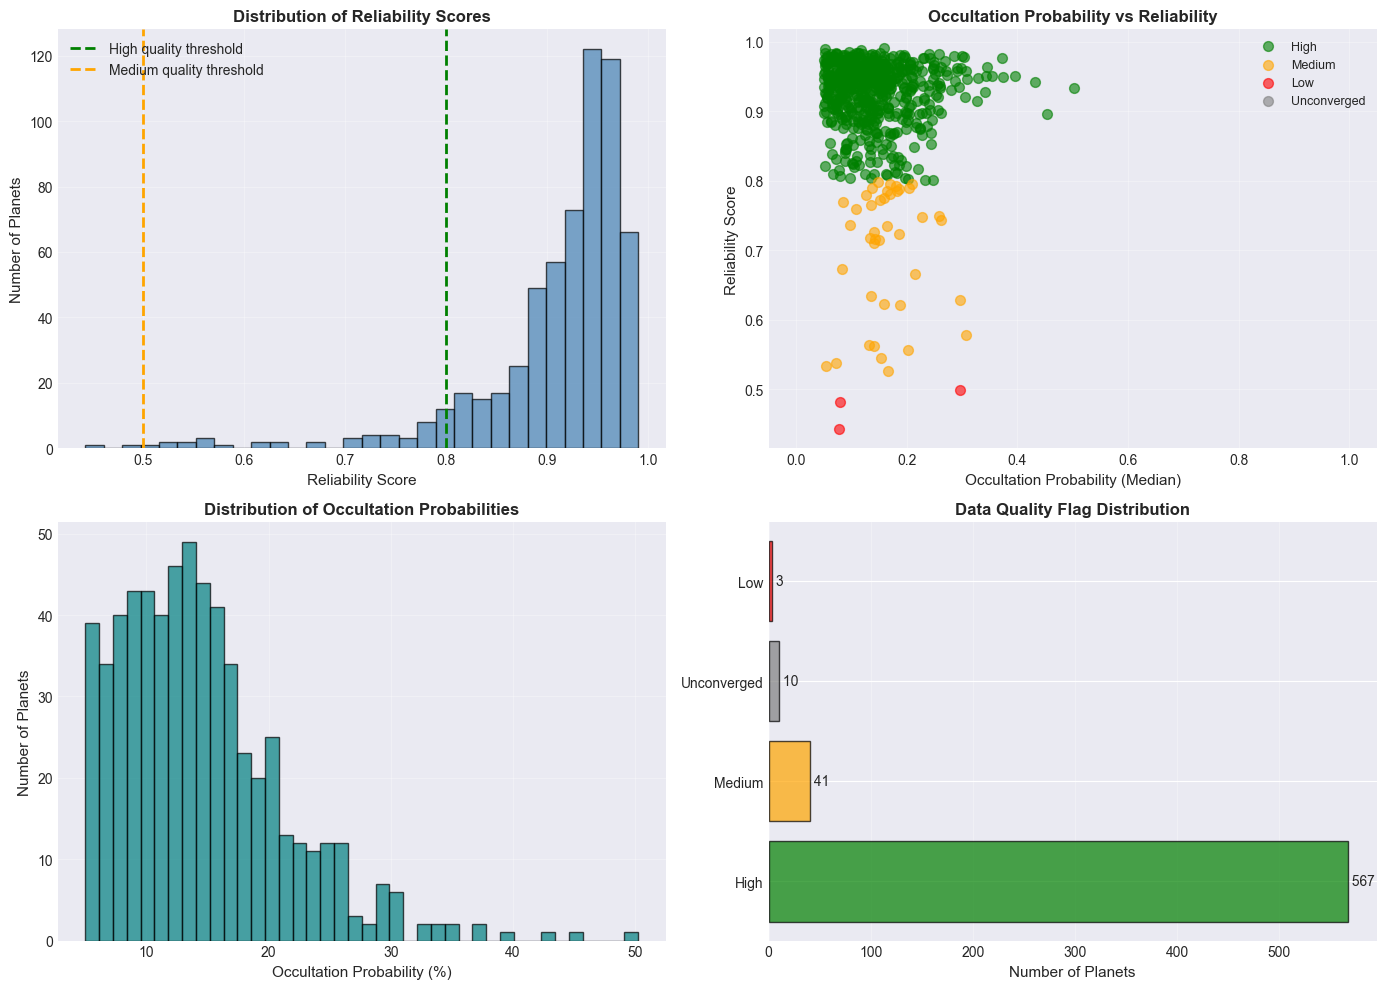


✓ Visualizations complete


In [13]:
print("="*80)
print("VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of reliability scores
ax1 = axes[0, 0]
results_valid = results_df[results_df['reliability'] > 0].copy()
if len(results_valid) > 0:
    ax1.hist(results_valid['reliability'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(0.8, color='green', linestyle='--', linewidth=2, label='High quality threshold')
    ax1.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Medium quality threshold')
    ax1.set_xlabel('Reliability Score', fontsize=11)
    ax1.set_ylabel('Number of Planets', fontsize=11)
    ax1.set_title('Distribution of Reliability Scores', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# 2. Scatter: Pocc_median vs reliability, colored by quality_flag
ax2 = axes[0, 1]
color_map = {'High': 'green', 'Medium': 'orange', 'Low': 'red', 'Anomaly': 'purple', 'Unconverged': 'gray'}
for flag, color in color_map.items():
    mask = results_df['quality_flag'] == flag
    if mask.any():
        ax2.scatter(results_df[mask]['Pocc_median'], results_df[mask]['reliability'],
                   alpha=0.6, s=50, label=flag, color=color)
ax2.set_xlabel('Occultation Probability (Median)', fontsize=11)
ax2.set_ylabel('Reliability Score', fontsize=11)
ax2.set_title('Occultation Probability vs Reliability', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.05, 1.05)

# 3. Distribution of occultation probabilities (posterior medians)
ax3 = axes[1, 0]
pocc_valid = results_df[results_df['Pocc_median'] > 0].copy()
if len(pocc_valid) > 0:
    ax3.hist(pocc_valid['Pocc_median'] * 100, bins=40, alpha=0.7, color='teal', edgecolor='black')
    ax3.set_xlabel('Occultation Probability (%)', fontsize=11)
    ax3.set_ylabel('Number of Planets', fontsize=11)
    ax3.set_title('Distribution of Occultation Probabilities', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)

# 4. Quality flag distribution
ax4 = axes[1, 1]
flag_counts = results_df['quality_flag'].value_counts()
colors = [color_map.get(flag, 'black') for flag in flag_counts.index]
ax4.barh(flag_counts.index, flag_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Number of Planets', fontsize=11)
ax4.set_title('Data Quality Flag Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add count labels
for i, v in enumerate(flag_counts.values):
    ax4.text(v, i, f' {v}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(project_root / 'analysis' / 'results' / 'mcmc_validation_summary.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved: mcmc_validation_summary.png")
plt.show()

print(f"\n✓ Visualizations complete")


EXTENDED VISUALIZATIONS: ECLIPSE DEPTH, TSM, ESM

✓ Extended visualizations saved: extended_metrics_visualization.png


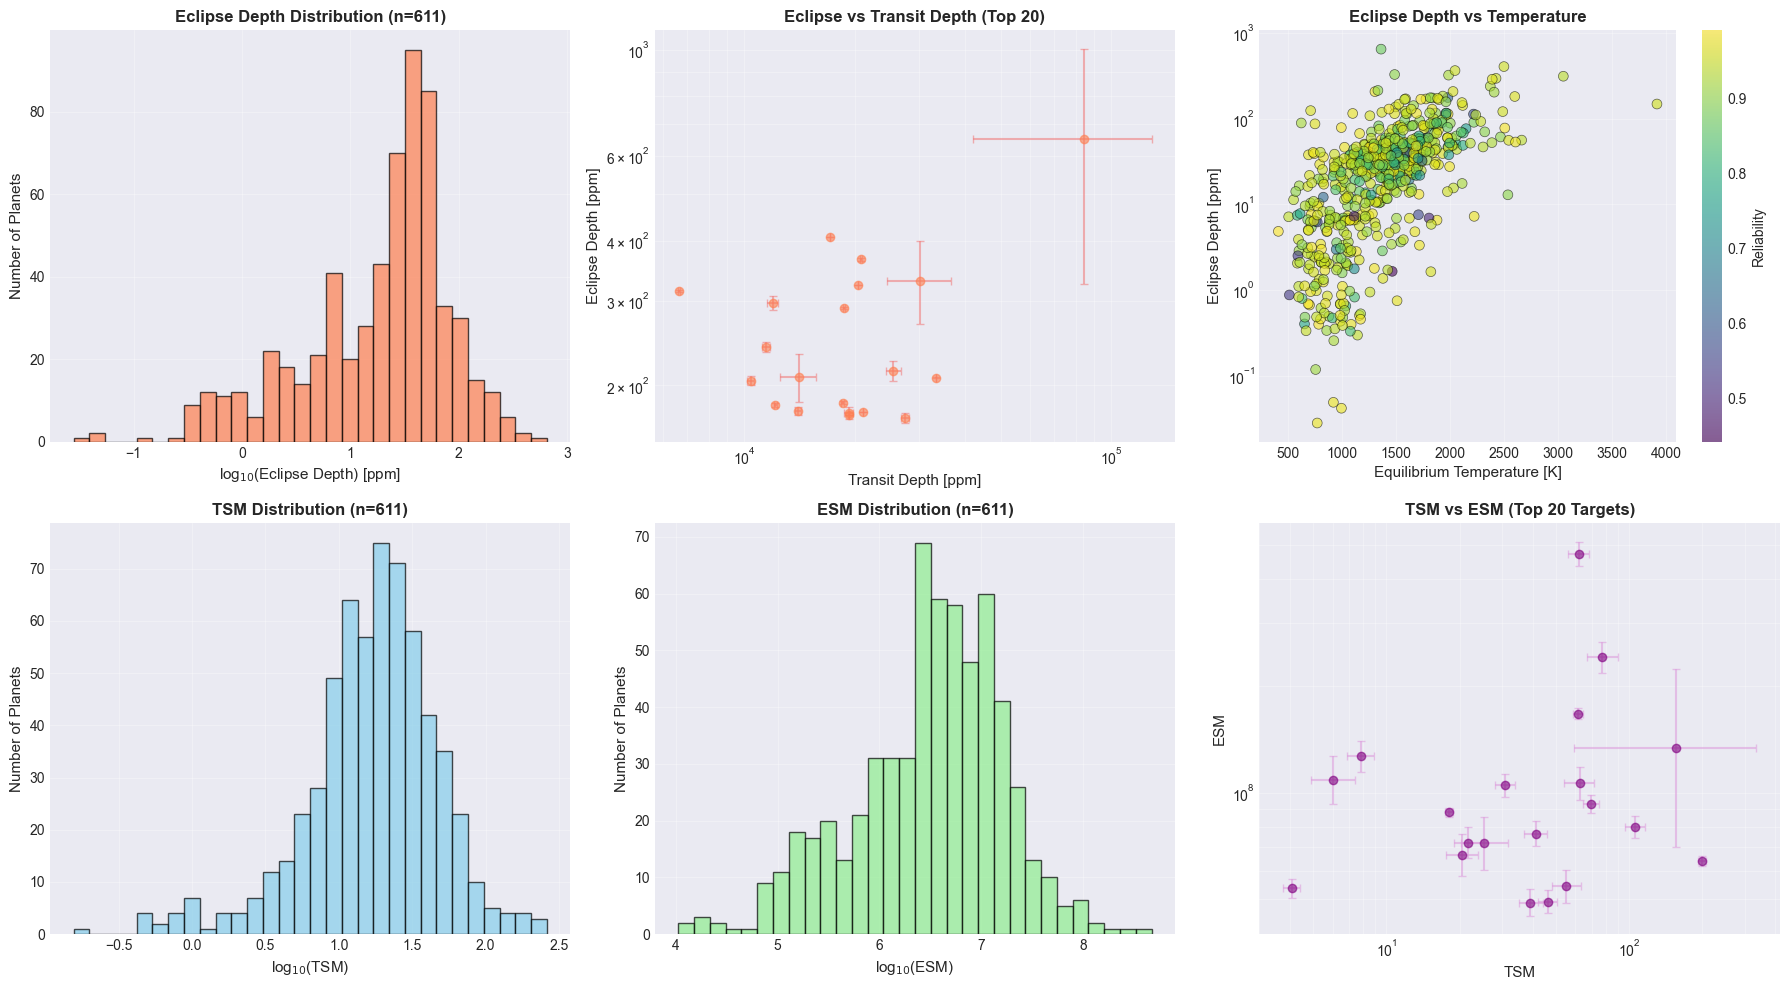


EXTENDED METRICS SUMMARY

Eclipse Depth (bolometric):
  Valid planets: 611
  Median: 29.0 ppm
  Range: 0.0 - 651.7 ppm
  Mean uncertainty: 3.7 ppm

Transmission Spectroscopy Metric (TSM):
  Valid planets: 611
  Median: 18.65
  Range: 0.16 - 261.23
  Mean uncertainty: 11.77
  Top 5 TSM targets:
    WASP-107 b                TSM =  261.2 ( 237.8 -  285.4)
    WASP-69 b                 TSM =  214.4 ( 189.0 -  241.9)
    HD 209458 b               TSM =  214.4 ( 203.4 -  226.2)
    HD 189733 b               TSM =  199.2 ( 191.7 -  206.8)
    KELT-11 b                 TSM =  196.0 ( 155.2 -  240.9)

Emission Spectroscopy Metric (ESM):
  Valid planets: 611
  Median: 3771923.68
  Range: 10577.27 - 471885953.67
  Mean uncertainty: 3148726.61
  Top 5 ESM targets:
    KELT-9 b                  ESM = 471885953.7 (435186729.9 - 510271166.9)
    WASP-33 b                 ESM = 240530799.3 (216839081.0 - 266386149.1)
    WASP-189 b                ESM = 166788028.3 (160699080.7 - 173078214.6)
    HIP

In [ ]:
# Additional visualizations for eclipse depth, TSM, and ESM
print("\n" + "="*80)
print("EXTENDED VISUALIZATIONS: ECLIPSE DEPTH, TSM, ESM")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Filter for valid data
eclipse_valid = results_df[results_df['Eclipse_depth_ppm'].notna() & (results_df['Eclipse_depth_ppm'] > 0)].copy()
tsm_valid = results_df[results_df['TSM_median'].notna() & (results_df['TSM_median'] > 0)].copy()
esm_valid = results_df[results_df['ESM_median'].notna() & (results_df['ESM_median'] > 0)].copy()

# 1. Eclipse Depth Distribution (log scale)
ax1 = axes[0, 0]
if len(eclipse_valid) > 0:
    ax1.hist(np.log10(eclipse_valid['Eclipse_depth_ppm']), bins=30, alpha=0.7, color='coral', edgecolor='black')
    ax1.set_xlabel('log$_{10}$(Eclipse Depth) [ppm]', fontsize=11)
    ax1.set_ylabel('Number of Planets', fontsize=11)
    ax1.set_title(f'Eclipse Depth Distribution (n={len(eclipse_valid)})', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No valid eclipse depth data', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Eclipse Depth Distribution', fontsize=12, fontweight='bold')

# 2. Eclipse Depth vs Transit Depth with error bars
ax2 = axes[0, 1]
if len(eclipse_valid) > 0:
    # Select top 20 planets for clarity
    display_data = eclipse_valid.nlargest(20, 'Eclipse_depth_ppm')
    
    y_err_lower = display_data['Eclipse_depth_median'] - display_data['Eclipse_depth_16']
    y_err_upper = display_data['Eclipse_depth_84'] - display_data['Eclipse_depth_median']
    x_err_lower = display_data['Transit_depth_median'] - display_data['Transit_depth_16']
    x_err_upper = display_data['Transit_depth_84'] - display_data['Transit_depth_median']
    
    ax2.errorbar(display_data['Transit_depth_ppm'], display_data['Eclipse_depth_ppm'],
                xerr=[x_err_lower*1e6, x_err_upper*1e6], yerr=[y_err_lower*1e6, y_err_upper*1e6],
                fmt='o', alpha=0.6, markersize=6, color='coral', ecolor='lightcoral', capsize=3)
    ax2.set_xlabel('Transit Depth [ppm]', fontsize=11)
    ax2.set_ylabel('Eclipse Depth [ppm]', fontsize=11)
    ax2.set_title('Eclipse vs Transit Depth (Top 20)', fontsize=12, fontweight='bold')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, which='both')
else:
    ax2.text(0.5, 0.5, 'No valid eclipse depth data', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Eclipse vs Transit Depth', fontsize=12, fontweight='bold')

# 3. Eclipse Depth vs Planet Temperature
ax3 = axes[0, 2]
temp_eclipse_valid = eclipse_valid[eclipse_valid['Planet_temp_median'].notna()].copy()
if len(temp_eclipse_valid) > 0:
    scatter = ax3.scatter(temp_eclipse_valid['Planet_temp_median'], 
                         temp_eclipse_valid['Eclipse_depth_ppm'],
                         c=temp_eclipse_valid['reliability'], cmap='viridis',
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('Equilibrium Temperature [K]', fontsize=11)
    ax3.set_ylabel('Eclipse Depth [ppm]', fontsize=11)
    ax3.set_title('Eclipse Depth vs Temperature', fontsize=12, fontweight='bold')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Reliability', fontsize=10)
else:
    ax3.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Eclipse Depth vs Temperature', fontsize=12, fontweight='bold')

# 4. TSM Distribution (log scale)
ax4 = axes[1, 0]
if len(tsm_valid) > 0:
    ax4.hist(np.log10(tsm_valid['TSM_median']), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.set_xlabel('log$_{10}$(TSM)', fontsize=11)
    ax4.set_ylabel('Number of Planets', fontsize=11)
    ax4.set_title(f'TSM Distribution (n={len(tsm_valid)})', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No valid TSM data', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('TSM Distribution', fontsize=12, fontweight='bold')

# 5. ESM Distribution (log scale)
ax5 = axes[1, 1]
if len(esm_valid) > 0:
    ax5.hist(np.log10(esm_valid['ESM_median']), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    ax5.set_xlabel('log$_{10}$(ESM)', fontsize=11)
    ax5.set_ylabel('Number of Planets', fontsize=11)
    ax5.set_title(f'ESM Distribution (n={len(esm_valid)})', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No valid ESM data', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('ESM Distribution', fontsize=12, fontweight='bold')

# 6. TSM vs ESM with error bars (top targets)
ax6 = axes[1, 2]
both_valid = results_df[(results_df['TSM_median'].notna()) & (results_df['ESM_median'].notna()) &
                        (results_df['TSM_median'] > 0) & (results_df['ESM_median'] > 0)].copy()
if len(both_valid) > 0:
    # Select top 20 by combined metric
    both_valid['combined_metric'] = both_valid['TSM_median'] + both_valid['ESM_median']
    display_data = both_valid.nlargest(20, 'combined_metric')
    
    x_err_lower = display_data['TSM_median'] - display_data['TSM_16']
    x_err_upper = display_data['TSM_84'] - display_data['TSM_median']
    y_err_lower = display_data['ESM_median'] - display_data['ESM_16']
    y_err_upper = display_data['ESM_84'] - display_data['ESM_median']
    
    ax6.errorbar(display_data['TSM_median'], display_data['ESM_median'],
                xerr=[x_err_lower, x_err_upper], yerr=[y_err_lower, y_err_upper],
                fmt='o', alpha=0.6, markersize=6, color='purple', ecolor='plum', capsize=3)
    ax6.set_xlabel('TSM', fontsize=11)
    ax6.set_ylabel('ESM', fontsize=11)
    ax6.set_title('TSM vs ESM (Top 20 Targets)', fontsize=12, fontweight='bold')
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3, which='both')
else:
    ax6.text(0.5, 0.5, 'No valid TSM/ESM data', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('TSM vs ESM', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(project_root / 'analysis' / 'results' / 'extended_metrics_visualization.png', 
            dpi=150, bbox_inches='tight')
print("\n✓ Extended visualizations saved: extended_metrics_visualization.png")
plt.show()

# Summary statistics
print("\n" + "="*80)
print("EXTENDED METRICS SUMMARY")
print("="*80)

if len(eclipse_valid) > 0:
    print(f"\nEclipse Depth (bolometric):")
    print(f"  Valid planets: {len(eclipse_valid)}")
    print(f"  Median: {eclipse_valid['Eclipse_depth_ppm'].median():.1f} ppm")
    print(f"  Range: {eclipse_valid['Eclipse_depth_ppm'].min():.1f} - {eclipse_valid['Eclipse_depth_ppm'].max():.1f} ppm")
    print(f"  Mean uncertainty: {(eclipse_valid['Eclipse_depth_84'] - eclipse_valid['Eclipse_depth_16']).mean() * 1e6:.1f} ppm")

if len(tsm_valid) > 0:
    print(f"\nTransmission Spectroscopy Metric (TSM):")
    print(f"  Valid planets: {len(tsm_valid)}")
    print(f"  Median: {tsm_valid['TSM_median'].median():.2f}")
    print(f"  Range: {tsm_valid['TSM_median'].min():.2f} - {tsm_valid['TSM_median'].max():.2f}")
    print(f"  Mean uncertainty: {(tsm_valid['TSM_84'] - tsm_valid['TSM_16']).mean():.2f}")
    print(f"  Top 5 TSM targets:")
    top_tsm = tsm_valid.nlargest(5, 'TSM_median')[['Planet Name', 'TSM_median', 'TSM_16', 'TSM_84']]
    for idx, row in top_tsm.iterrows():
        print(f"    {row['Planet Name']:25s} TSM = {row['TSM_median']:6.1f} ({row['TSM_16']:6.1f} - {row['TSM_84']:6.1f})")

if len(esm_valid) > 0:
    print(f"\nEmission Spectroscopy Metric (ESM):")
    print(f"  Valid planets: {len(esm_valid)}")
    print(f"  Median: {esm_valid['ESM_median'].median():.2f}")
    print(f"  Range: {esm_valid['ESM_median'].min():.2f} - {esm_valid['ESM_median'].max():.2f}")
    print(f"  Mean uncertainty: {(esm_valid['ESM_84'] - esm_valid['ESM_16']).mean():.2f}")
    print(f"  Top 5 ESM targets:")
    top_esm = esm_valid.nlargest(5, 'ESM_median')[['Planet Name', 'ESM_median', 'ESM_16', 'ESM_84']]
    for idx, row in top_esm.iterrows():
        print(f"    {row['Planet Name']:25s} ESM = {row['ESM_median']:6.1f} ({row['ESM_16']:6.1f} - {row['ESM_84']:6.1f})")

print("\n✓ Extended visualization complete")


TPC VISUALIZATIONS

✓ TPC quality visualization saved: tpc_quality_visualization.png


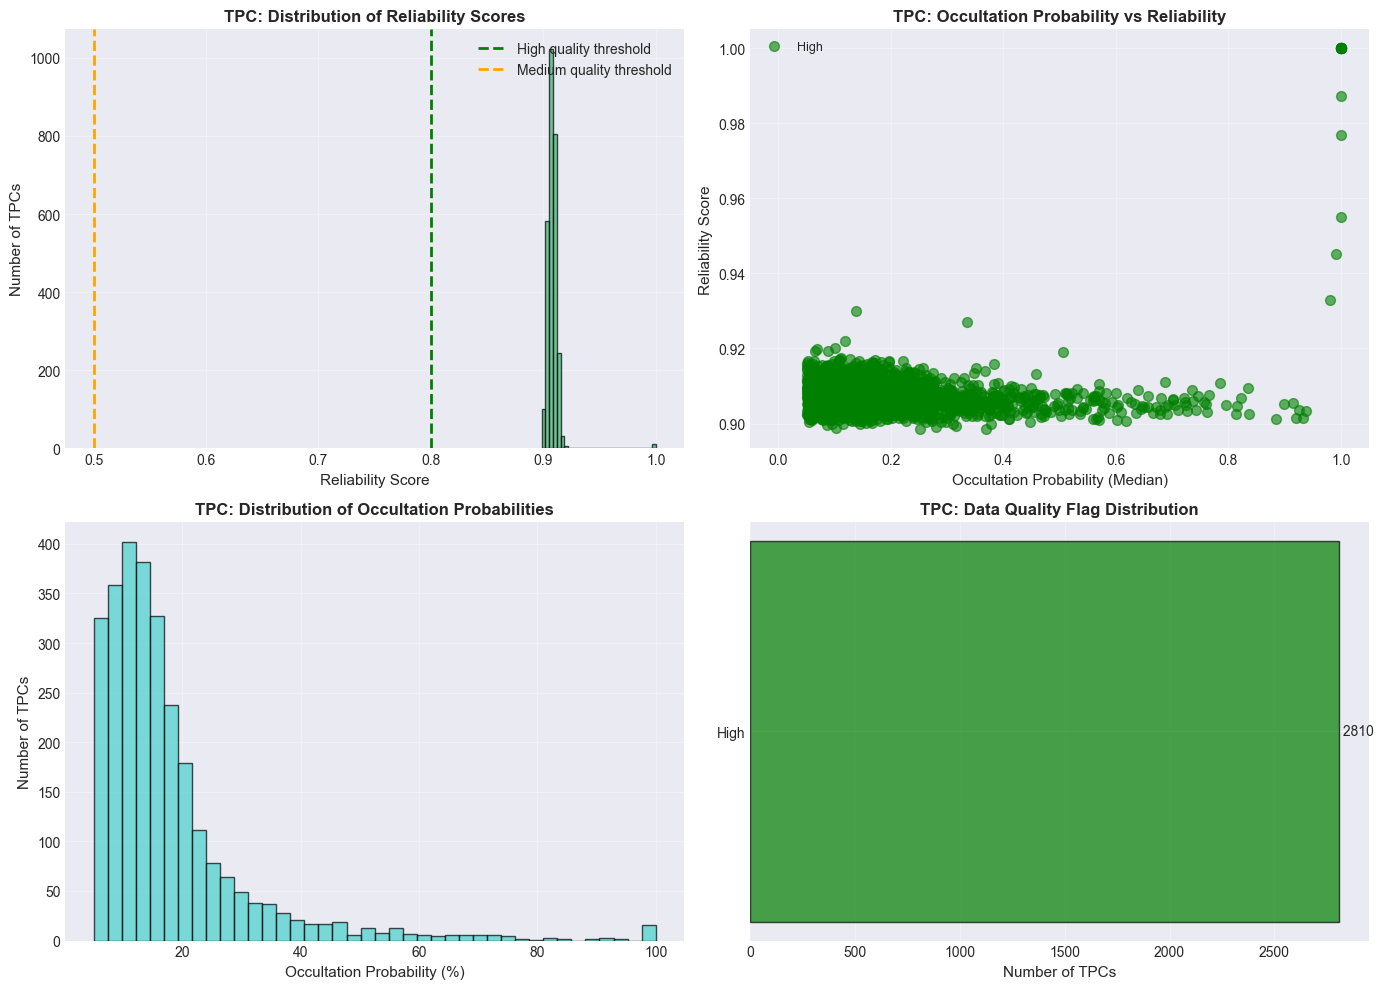


TPC EXTENDED VISUALIZATIONS: ECLIPSE DEPTH, TSM, ESM

✓ TPC extended visualizations saved: tpc_extended_metrics_visualization.png


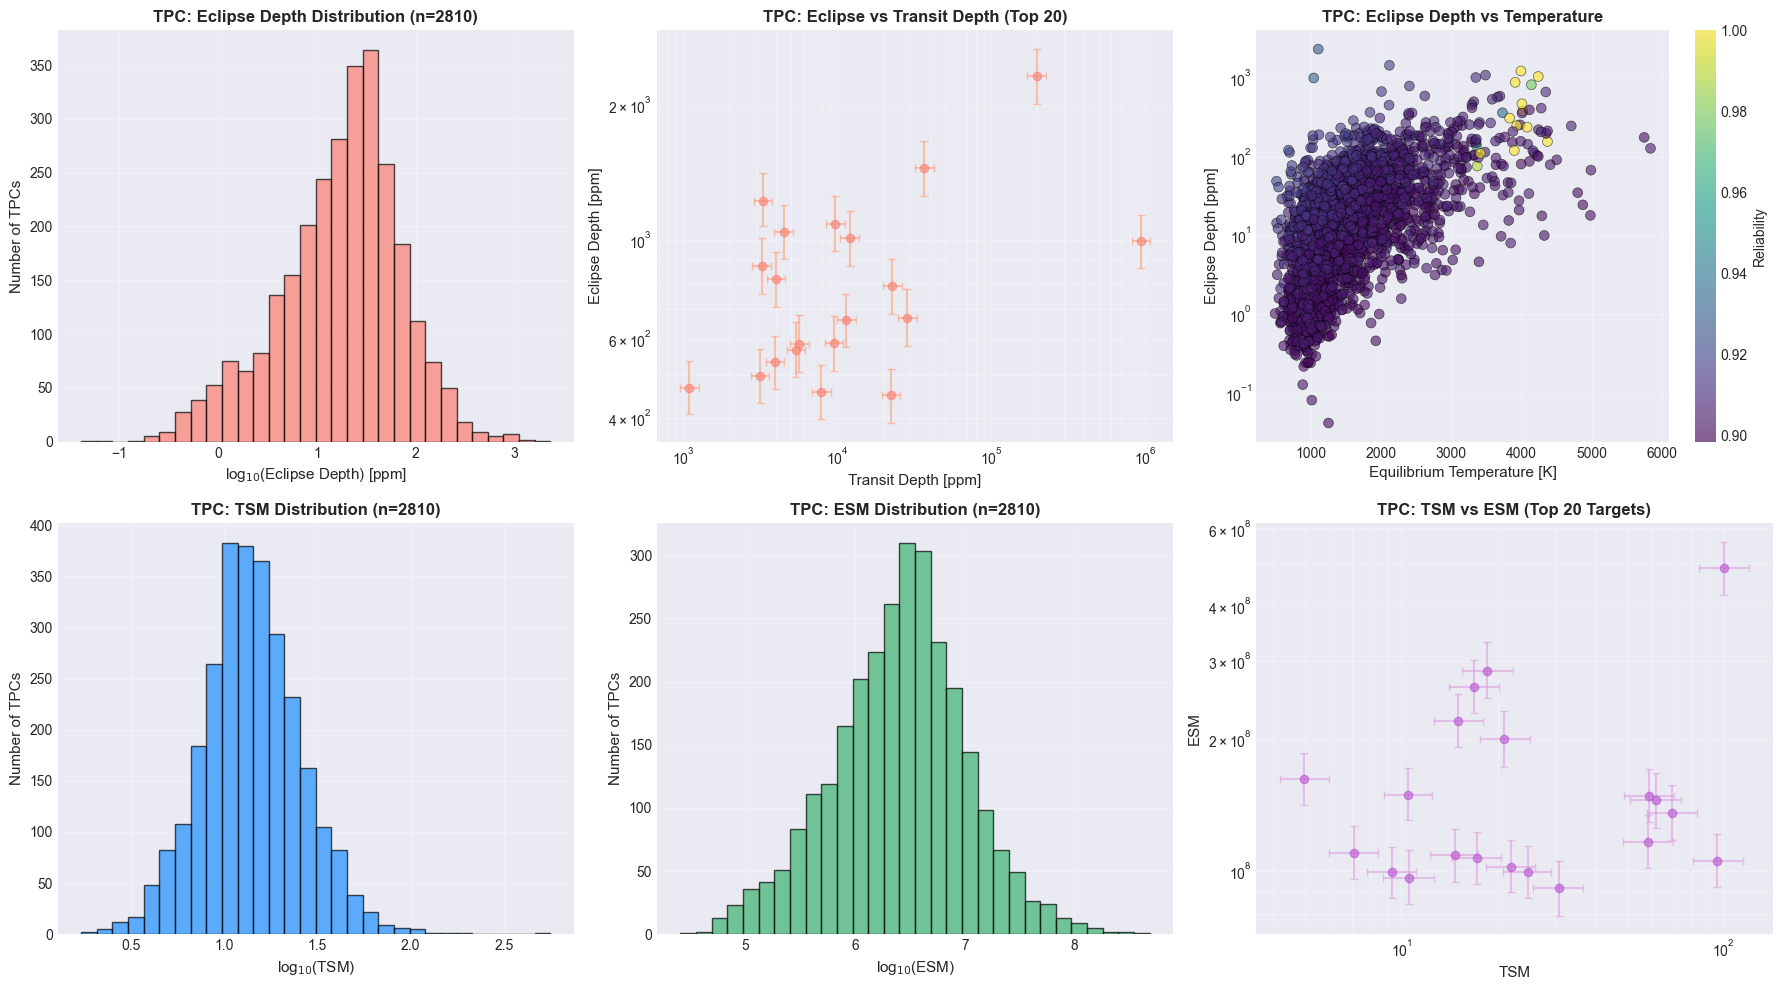


✓ All TPC visualizations complete


In [14]:
# TPC Visualizations
print("\n" + "="*80)
print("TPC VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of reliability scores for TPCs
ax1 = axes[0, 0]
results_valid_tpc = results_df_tpc[results_df_tpc['reliability'] > 0].copy()
if len(results_valid_tpc) > 0:
    ax1.hist(results_valid_tpc['reliability'], bins=30, alpha=0.7, color='mediumseagreen', edgecolor='black')
    ax1.axvline(0.8, color='green', linestyle='--', linewidth=2, label='High quality threshold')
    ax1.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Medium quality threshold')
    ax1.set_xlabel('Reliability Score', fontsize=11)
    ax1.set_ylabel('Number of TPCs', fontsize=11)
    ax1.set_title('TPC: Distribution of Reliability Scores', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# 2. Scatter: Pocc_median vs reliability for TPCs, colored by quality_flag
ax2 = axes[0, 1]
color_map = {'High': 'green', 'Medium': 'orange', 'Low': 'red', 'Anomaly': 'purple', 'Unconverged': 'gray'}
for flag, color in color_map.items():
    mask = results_df_tpc['quality_flag'] == flag
    if mask.any():
        ax2.scatter(results_df_tpc[mask]['Pocc_median'], results_df_tpc[mask]['reliability'],
                   alpha=0.6, s=50, label=flag, color=color)
ax2.set_xlabel('Occultation Probability (Median)', fontsize=11)
ax2.set_ylabel('Reliability Score', fontsize=11)
ax2.set_title('TPC: Occultation Probability vs Reliability', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.05, 1.05)

# 3. Distribution of occultation probabilities for TPCs (posterior medians)
ax3 = axes[1, 0]
pocc_valid_tpc = results_df_tpc[results_df_tpc['Pocc_median'] > 0].copy()
if len(pocc_valid_tpc) > 0:
    ax3.hist(pocc_valid_tpc['Pocc_median'] * 100, bins=40, alpha=0.7, color='mediumturquoise', edgecolor='black')
    ax3.set_xlabel('Occultation Probability (%)', fontsize=11)
    ax3.set_ylabel('Number of TPCs', fontsize=11)
    ax3.set_title('TPC: Distribution of Occultation Probabilities', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)

# 4. Quality flag distribution for TPCs
ax4 = axes[1, 1]
flag_counts_tpc = results_df_tpc['quality_flag'].value_counts()
colors = [color_map.get(flag, 'black') for flag in flag_counts_tpc.index]
ax4.barh(flag_counts_tpc.index, flag_counts_tpc.values, color=colors, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Number of TPCs', fontsize=11)
ax4.set_title('TPC: Data Quality Flag Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add count labels
for i, v in enumerate(flag_counts_tpc.values):
    ax4.text(v, i, f' {v}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(project_root / 'analysis' / 'results' / 'tpc_quality_visualization.png', 
            dpi=150, bbox_inches='tight')
print("\n✓ TPC quality visualization saved: tpc_quality_visualization.png")
plt.show()

# TPC Extended Metrics Visualizations
print("\n" + "="*80)
print("TPC EXTENDED VISUALIZATIONS: ECLIPSE DEPTH, TSM, ESM")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Filter for valid data
eclipse_valid_tpc = results_df_tpc[results_df_tpc['Eclipse_depth_ppm'].notna() & (results_df_tpc['Eclipse_depth_ppm'] > 0)].copy()
tsm_valid_tpc = results_df_tpc[results_df_tpc['TSM_median'].notna() & (results_df_tpc['TSM_median'] > 0)].copy()
esm_valid_tpc = results_df_tpc[results_df_tpc['ESM_median'].notna() & (results_df_tpc['ESM_median'] > 0)].copy()

# 1. Eclipse Depth Distribution (log scale)
ax1 = axes[0, 0]
if len(eclipse_valid_tpc) > 0:
    ax1.hist(np.log10(eclipse_valid_tpc['Eclipse_depth_ppm']), bins=30, alpha=0.7, color='salmon', edgecolor='black')
    ax1.set_xlabel('log$_{10}$(Eclipse Depth) [ppm]', fontsize=11)
    ax1.set_ylabel('Number of TPCs', fontsize=11)
    ax1.set_title(f'TPC: Eclipse Depth Distribution (n={len(eclipse_valid_tpc)})', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No valid eclipse depth data', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('TPC: Eclipse Depth Distribution', fontsize=12, fontweight='bold')

# 2. Eclipse Depth vs Transit Depth with error bars
ax2 = axes[0, 1]
if len(eclipse_valid_tpc) > 0:
    # Select top 20 TPCs for clarity
    display_data_tpc = eclipse_valid_tpc.nlargest(20, 'Eclipse_depth_ppm')
    
    y_err_lower = display_data_tpc['Eclipse_depth_median'] - display_data_tpc['Eclipse_depth_16']
    y_err_upper = display_data_tpc['Eclipse_depth_84'] - display_data_tpc['Eclipse_depth_median']
    x_err_lower = display_data_tpc['Transit_depth_median'] - display_data_tpc['Transit_depth_16']
    x_err_upper = display_data_tpc['Transit_depth_84'] - display_data_tpc['Transit_depth_median']
    
    ax2.errorbar(display_data_tpc['Transit_depth_ppm'], display_data_tpc['Eclipse_depth_ppm'],
                xerr=[x_err_lower*1e6, x_err_upper*1e6], yerr=[y_err_lower*1e6, y_err_upper*1e6],
                fmt='o', alpha=0.6, markersize=6, color='salmon', ecolor='lightsalmon', capsize=3)
    ax2.set_xlabel('Transit Depth [ppm]', fontsize=11)
    ax2.set_ylabel('Eclipse Depth [ppm]', fontsize=11)
    ax2.set_title('TPC: Eclipse vs Transit Depth (Top 20)', fontsize=12, fontweight='bold')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, which='both')
else:
    ax2.text(0.5, 0.5, 'No valid eclipse depth data', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('TPC: Eclipse vs Transit Depth', fontsize=12, fontweight='bold')

# 3. Eclipse Depth vs Planet Temperature
ax3 = axes[0, 2]
temp_eclipse_valid_tpc = eclipse_valid_tpc[eclipse_valid_tpc['Planet_temp_median'].notna()].copy()
if len(temp_eclipse_valid_tpc) > 0:
    scatter = ax3.scatter(temp_eclipse_valid_tpc['Planet_temp_median'], 
                         temp_eclipse_valid_tpc['Eclipse_depth_ppm'],
                         c=temp_eclipse_valid_tpc['reliability'], cmap='viridis',
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('Equilibrium Temperature [K]', fontsize=11)
    ax3.set_ylabel('Eclipse Depth [ppm]', fontsize=11)
    ax3.set_title('TPC: Eclipse Depth vs Temperature', fontsize=12, fontweight='bold')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Reliability', fontsize=10)
else:
    ax3.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('TPC: Eclipse Depth vs Temperature', fontsize=12, fontweight='bold')

# 4. TSM Distribution (log scale)
ax4 = axes[1, 0]
if len(tsm_valid_tpc) > 0:
    ax4.hist(np.log10(tsm_valid_tpc['TSM_median']), bins=30, alpha=0.7, color='dodgerblue', edgecolor='black')
    ax4.set_xlabel('log$_{10}$(TSM)', fontsize=11)
    ax4.set_ylabel('Number of TPCs', fontsize=11)
    ax4.set_title(f'TPC: TSM Distribution (n={len(tsm_valid_tpc)})', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No valid TSM data', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('TPC: TSM Distribution', fontsize=12, fontweight='bold')

# 5. ESM Distribution (log scale)
ax5 = axes[1, 1]
if len(esm_valid_tpc) > 0:
    ax5.hist(np.log10(esm_valid_tpc['ESM_median']), bins=30, alpha=0.7, color='mediumseagreen', edgecolor='black')
    ax5.set_xlabel('log$_{10}$(ESM)', fontsize=11)
    ax5.set_ylabel('Number of TPCs', fontsize=11)
    ax5.set_title(f'TPC: ESM Distribution (n={len(esm_valid_tpc)})', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No valid ESM data', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('TPC: ESM Distribution', fontsize=12, fontweight='bold')

# 6. TSM vs ESM with error bars (top targets)
ax6 = axes[1, 2]
both_valid_tpc = results_df_tpc[(results_df_tpc['TSM_median'].notna()) & (results_df_tpc['ESM_median'].notna()) &
                                (results_df_tpc['TSM_median'] > 0) & (results_df_tpc['ESM_median'] > 0)].copy()
if len(both_valid_tpc) > 0:
    # Select top 20 by combined metric
    both_valid_tpc['combined_metric'] = both_valid_tpc['TSM_median'] + both_valid_tpc['ESM_median']
    display_data_tpc = both_valid_tpc.nlargest(20, 'combined_metric')
    
    x_err_lower = display_data_tpc['TSM_median'] - display_data_tpc['TSM_16']
    x_err_upper = display_data_tpc['TSM_84'] - display_data_tpc['TSM_median']
    y_err_lower = display_data_tpc['ESM_median'] - display_data_tpc['ESM_16']
    y_err_upper = display_data_tpc['ESM_84'] - display_data_tpc['ESM_median']
    
    ax6.errorbar(display_data_tpc['TSM_median'], display_data_tpc['ESM_median'],
                xerr=[x_err_lower, x_err_upper], yerr=[y_err_lower, y_err_upper],
                fmt='o', alpha=0.6, markersize=6, color='mediumorchid', ecolor='plum', capsize=3)
    ax6.set_xlabel('TSM', fontsize=11)
    ax6.set_ylabel('ESM', fontsize=11)
    ax6.set_title('TPC: TSM vs ESM (Top 20 Targets)', fontsize=12, fontweight='bold')
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3, which='both')
else:
    ax6.text(0.5, 0.5, 'No valid TSM/ESM data', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('TPC: TSM vs ESM', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(project_root / 'analysis' / 'results' / 'tpc_extended_metrics_visualization.png', 
            dpi=150, bbox_inches='tight')
print("\n✓ TPC extended visualizations saved: tpc_extended_metrics_visualization.png")
plt.show()

print("\n✓ All TPC visualizations complete")

In [ ]:
# # Corner plot for representative benchmark planet
# print("\nGenerating corner plot for representative benchmark planet...\n")

# # Select a high-quality benchmark planet
# high_qual_benchmarks = benchmark_df[benchmark_df['converged'] & (benchmark_df['reliability'] > 0.7)]

# if len(high_qual_benchmarks) > 0:
#     rep_planet_name = high_qual_benchmarks.iloc[0]['Planet Name']
#     rep_planet = df_known[df_known['Planet Name'].str.contains(rep_planet_name.split()[0], case=False, na=False)].iloc[0]
    
#     print(f"Generating corner plot for: {rep_planet_name}")
#     print(f"(Posterior samples from MCMC with 16 walkers, 1500 post-burn-in steps)")
    
#     try:
#         # Re-run MCMC for this planet with full samples for corner plot
#         sampler = emcee.EnsembleSampler(
#             16,
#             ndim=2,
#             log_prob_fn=log_probability_wrapper,
#             args=(rep_planet,)
#         )
        
#         # Get stellar radius error - try multiple column names
#         obs_stellar_rad = rep_planet['Star Radius [Rs]']
#         if 'Star Radius Error Lower [Rs]' in rep_planet.index and 'Star Radius Error Upper [Rs]' in rep_planet.index:
#             err_stellar_rad = (abs(rep_planet['Star Radius Error Lower [Rs]']) + abs(rep_planet['Star Radius Error Upper [Rs]'])) / 2
#         elif 'Star Radius_error_[Rs]' in rep_planet.index:
#             err_stellar_rad = rep_planet['Star Radius_error_[Rs]']
#         else:
#             err_stellar_rad = obs_stellar_rad * 0.05
        
#         # Get planet radius error - try multiple column names
#         obs_planet_rad = rep_planet['Planet Radius [Rj]']
#         if 'Planet Radius Error Lower [Rj]' in rep_planet.index and 'Planet Radius Error Upper [Rj]' in rep_planet.index:
#             err_planet_rad = (abs(rep_planet['Planet Radius Error Lower [Rj]']) + abs(rep_planet['Planet Radius Error Upper [Rj]'])) / 2
#         elif 'Planet Radius_error_[Rj]' in rep_planet.index:
#             err_planet_rad = rep_planet['Planet Radius_error_[Rj]']
#         else:
#             err_planet_rad = obs_planet_rad * 0.05
        
#         # Ensure positive errors
#         err_stellar_rad = max(err_stellar_rad, obs_stellar_rad * 0.01)
#         err_planet_rad = max(err_planet_rad, obs_planet_rad * 0.01)
        
#         p0 = np.random.normal(
#             loc=[obs_stellar_rad, obs_planet_rad],
#             scale=[err_stellar_rad, err_planet_rad],
#             size=(16, 2)
#         )
#         p0 = np.abs(p0)
        
#         sampler.run_mcmc(p0, 1500, progress=False)
#         samples = sampler.get_chain(discard=500, flat=True)
        
#         # Create corner plot
#         fig = corner.corner(
#             samples,
#             labels=[r'$R_{\star}$ $(R_{\odot})$', r'$R_p$ $(R_{\rm Jup})$'],
#             truths=[rep_planet['Star Radius [Rs]'], rep_planet['Planet Radius [Rj]']],
#             truth_color='red',
#             quantiles=[0.16, 0.5, 0.84],
#             show_titles=True,
#             title_kwargs={"fontsize": 10}
#         )
        
#         fig.suptitle(f'MCMC Posterior Distributions: {rep_planet_name}', fontsize=14, fontweight='bold', y=1.00)
#         plt.savefig(project_root / 'analysis' / 'results' / f'corner_plot_{rep_planet_name.replace(" ", "_")}.png',
#                    dpi=150, bbox_inches='tight')
#         print(f"✓ Corner plot saved: corner_plot_{rep_planet_name.replace(' ', '_')}.png")
#         plt.show()
        
#     except Exception as e:
#         print(f"⚠ Could not generate corner plot: {e}")
# else:
#     print("⚠ No high-quality benchmark planets for corner plot")

# print("\n✓ All visualizations complete")

## Section 9: Export Results

In [15]:
print("="*80)
print("EXPORTING RESULTS")
print("="*80)

# Prepare export DataFrame with key columns
export_columns = [
    'Planet Name', 'Star Name',
    'Pocc_median', 'Pocc_16', 'Pocc_84', 'uncertainty_range',
    'Transit_depth_median', 'Transit_depth_16', 'Transit_depth_84', 'Transit_depth_ppm', 'Transit_depth_source',
    'Eclipse_depth_median', 'Eclipse_depth_16', 'Eclipse_depth_84', 'Eclipse_depth_ppm',
    'Planet_temp_median', 'Planet_temp_source',
    'TSM_median', 'TSM_16', 'TSM_84',
    'ESM_median', 'ESM_16', 'ESM_84',
    'reliability', 'quality_flag', 'converged'
]

export_cols_available = [col for col in export_columns if col in results_df.columns]
export_df = results_df[export_cols_available].copy()

# Rename columns for clarity
column_names = []
for col in export_cols_available:
    if col == 'Planet Name':
        column_names.append('Planet Name')
    elif col == 'Star Name':
        column_names.append('Star Name')
    elif col == 'Pocc_median':
        column_names.append('Pocc_median')
    elif col == 'Pocc_16':
        column_names.append('Pocc_16 (lower)')
    elif col == 'Pocc_84':
        column_names.append('Pocc_84 (upper)')
    elif col == 'uncertainty_range':
        column_names.append('Uncertainty Range')
    elif col == 'Transit_depth_median':
        column_names.append('Transit_depth_median')
    elif col == 'Transit_depth_16':
        column_names.append('Transit_depth_16 (lower)')
    elif col == 'Transit_depth_84':
        column_names.append('Transit_depth_84 (upper)')
    elif col == 'Transit_depth_ppm':
        column_names.append('Transit_depth_ppm')
    elif col == 'Transit_depth_source':
        column_names.append('Transit_depth_source')
    elif col == 'Eclipse_depth_median':
        column_names.append('Eclipse_depth_median')
    elif col == 'Eclipse_depth_16':
        column_names.append('Eclipse_depth_16 (lower)')
    elif col == 'Eclipse_depth_84':
        column_names.append('Eclipse_depth_84 (upper)')
    elif col == 'Eclipse_depth_ppm':
        column_names.append('Eclipse_depth_ppm')
    elif col == 'Planet_temp_median':
        column_names.append('Planet_Teq_K')
    elif col == 'Planet_temp_source':
        column_names.append('Planet_temp_source')
    elif col == 'TSM_median':
        column_names.append('TSM_median')
    elif col == 'TSM_16':
        column_names.append('TSM_16 (lower)')
    elif col == 'TSM_84':
        column_names.append('TSM_84 (upper)')
    elif col == 'ESM_median':
        column_names.append('ESM_median')
    elif col == 'ESM_16':
        column_names.append('ESM_16 (lower)')
    elif col == 'ESM_84':
        column_names.append('ESM_84 (upper)')
    elif col == 'reliability':
        column_names.append('Reliability Score')
    elif col == 'quality_flag':
        column_names.append('Data Quality')
    elif col == 'converged':
        column_names.append('MCMC Converged')
    else:
        column_names.append(col)

export_df.columns = column_names

# Sort by reliability (descending)
export_df = export_df.sort_values('Reliability Score', ascending=False, na_position='last')

# Save to CSV with _known suffix
output_file = results_path / 'mcs_mcmc_uncertainties_known.csv'
export_df.to_csv(output_file, index=False)

print(f"\n✓ Known planets results exported to: {output_file.name}")
print(f"  Total rows: {len(export_df)}")
print(f"  Columns: {len(export_df.columns)}")

# Display summary statistics
print("\n" + "="*80)
print("EXPORT SUMMARY STATISTICS")
print("="*80)

print(f"\nMedian Occultation Probability:")
print(f"  Mean:     {export_df['Pocc_median'].mean():.4f}")
print(f"  Median:   {export_df['Pocc_median'].median():.4f}")
print(f"  Std Dev:  {export_df['Pocc_median'].std():.4f}")

if 'Transit_depth_ppm' in export_df.columns:
    print(f"\nTransit Depth:")
    transit_valid = export_df['Transit_depth_ppm'].dropna()
    if len(transit_valid) > 0:
        print(f"  Mean:     {transit_valid.mean():.1f} ppm")
        print(f"  Median:   {transit_valid.median():.1f} ppm")
        print(f"  Std Dev:  {transit_valid.std():.1f} ppm")
    else:
        print(f"  No valid transit depth measurements")

if 'Transit_depth_source' in export_df.columns:
    print(f"\nTransit Depth Data Source:")
    for source in export_df['Transit_depth_source'].unique():
        count = (export_df['Transit_depth_source'] == source).sum()
        pct = 100 * count / len(export_df)
        print(f"  {source:12s}: {count:4d} ({pct:5.1f}%)")

if 'Eclipse_depth_ppm' in export_df.columns:
    print(f"\nEclipse Depth (bolometric):")
    eclipse_valid = export_df['Eclipse_depth_ppm'].dropna()
    if len(eclipse_valid) > 0:
        print(f"  Mean:     {eclipse_valid.mean():.1f} ppm")
        print(f"  Median:   {eclipse_valid.median():.1f} ppm")
        print(f"  Std Dev:  {eclipse_valid.std():.1f} ppm")
    else:
        print(f"  No valid eclipse depth measurements")

if 'Planet_Teq_K' in export_df.columns:
    print(f"\nEquilibrium Temperature:")
    temp_valid = export_df['Planet_Teq_K'].dropna()
    if len(temp_valid) > 0:
        print(f"  Mean:     {temp_valid.mean():.0f} K")
        print(f"  Median:   {temp_valid.median():.0f} K")
        print(f"  Std Dev:  {temp_valid.std():.0f} K")

if 'Planet_temp_source' in export_df.columns:
    print(f"\nTemperature Data Source:")
    for source in export_df['Planet_temp_source'].unique():
        count = (export_df['Planet_temp_source'] == source).sum()
        pct = 100 * count / len(export_df)
        print(f"  {source:12s}: {count:4d} ({pct:5.1f}%)")

if 'TSM_median' in export_df.columns:
    print(f"\nTransmission Spectroscopy Metric (TSM):")
    tsm_valid = export_df['TSM_median'].dropna()
    if len(tsm_valid) > 0:
        print(f"  Mean:     {tsm_valid.mean():.1f}")
        print(f"  Median:   {tsm_valid.median():.1f}")
        print(f"  Std Dev:  {tsm_valid.std():.1f}")
        print(f"  Valid:    {len(tsm_valid)} ({100*len(tsm_valid)/len(export_df):.1f}%)")
    else:
        print(f"  No valid TSM measurements")

if 'ESM_median' in export_df.columns:
    print(f"\nEmission Spectroscopy Metric (ESM):")
    esm_valid = export_df['ESM_median'].dropna()
    if len(esm_valid) > 0:
        print(f"  Mean:     {esm_valid.mean():.1f}")
        print(f"  Median:   {esm_valid.median():.1f}")
        print(f"  Std Dev:  {esm_valid.std():.1f}")
        print(f"  Valid:    {len(esm_valid)} ({100*len(esm_valid)/len(export_df):.1f}%)")
    else:
        print(f"  No valid ESM measurements")

print(f"\nReliability Scores:")
print(f"  Mean:     {export_df['Reliability Score'].mean():.4f}")
print(f"  Median:   {export_df['Reliability Score'].median():.4f}")
print(f"  Std Dev:  {export_df['Reliability Score'].std():.4f}")

print(f"\nData Quality Distribution:")
for quality in export_df['Data Quality'].unique():
    count = (export_df['Data Quality'] == quality).sum()
    pct = 100 * count / len(export_df)
    print(f"  {quality:12s}: {count:4d} ({pct:5.1f}%)")

print(f"\nConvergence Status:")
converged = export_df['MCMC Converged'].sum()
total = len(export_df)
print(f"  Successful: {converged:4d} ({100*converged/total:.1f}%)")
print(f"  Failed:     {total-converged:4d} ({100*(total-converged)/total:.1f}%)")

# Display top 10 highest reliability planets
print("\n" + "="*80)
print("TOP 10 HIGHEST RELIABILITY PLANETS")
print("="*80)
display_cols = ['Planet Name', 'Pocc_median', 'Transit_depth_ppm', 'Transit_depth_source', 'Eclipse_depth_ppm', 'Reliability Score', 'Data Quality']
available_display_cols = [col for col in display_cols if col in export_df.columns]
top_10 = export_df.head(10)[available_display_cols]
for idx, row in top_10.iterrows():
    transit_src = f"({row['Transit_depth_source']})" if 'Transit_depth_source' in row.index else ""
    transit_str = f"Tra={row['Transit_depth_ppm']:6.0f}ppm{transit_src}" if 'Transit_depth_ppm' in row.index and not np.isnan(row['Transit_depth_ppm']) else "Tra=N/A"
    eclipse_str = f"Ecl={row['Eclipse_depth_ppm']:5.0f}ppm" if 'Eclipse_depth_ppm' in row.index and not np.isnan(row['Eclipse_depth_ppm']) else "Ecl=N/A"
    print(f"  {row['Planet Name']:25s} P_occ={row['Pocc_median']:.4f} {transit_str} {eclipse_str} Rel={row['Reliability Score']:.3f} ({row['Data Quality']})")

print("\n✓ Export complete")

EXPORTING RESULTS

✓ Known planets results exported to: mcs_mcmc_uncertainties_known.csv
  Total rows: 621
  Columns: 26

EXPORT SUMMARY STATISTICS

Median Occultation Probability:
  Mean:     0.1444
  Median:   0.1347
  Std Dev:  0.0675

Transit Depth:
  Mean:     9533.1 ppm
  Median:   8187.3 ppm
  Std Dev:  8433.2 ppm

Transit Depth Data Source:
  dataset     :  582 ( 93.7%)
  calculated  :   29 (  4.7%)
  none        :   10 (  1.6%)

Eclipse Depth (bolometric):
  Mean:     41.3 ppm
  Median:   29.0 ppm
  Std Dev:  56.4 ppm

Equilibrium Temperature:
  Mean:     1361 K
  Median:   1366 K
  Std Dev:  449 K

Temperature Data Source:
  dataset     :  611 ( 98.4%)
  none        :   10 (  1.6%)

Transmission Spectroscopy Metric (TSM):
  Mean:     26.4
  Median:   18.7
  Std Dev:  29.3
  Valid:    611 (98.4%)

Emission Spectroscopy Metric (ESM):
  Mean:     10027338.0
  Median:   3771923.7
  Std Dev:  26730843.6
  Valid:    611 (98.4%)

Reliability Scores:
  Mean:     0.9102
  Median:   0.

In [17]:
print("="*80)
print("EXPORTING TPC RESULTS")
print("="*80)

# Prepare export DataFrame with key columns for TPCs
export_columns_tpc = [
    'Planet Name', 'Star Name',
    'Pocc_median', 'Pocc_16', 'Pocc_84', 'uncertainty_range',
    'Transit_depth_median', 'Transit_depth_16', 'Transit_depth_84', 'Transit_depth_ppm', 'Transit_depth_source',
    'Eclipse_depth_median', 'Eclipse_depth_16', 'Eclipse_depth_84', 'Eclipse_depth_ppm',
    'Planet_temp_median', 'Planet_temp_source',
    'TSM_median', 'TSM_16', 'TSM_84',
    'ESM_median', 'ESM_16', 'ESM_84',
    'reliability', 'quality_flag', 'converged'
]

export_cols_available_tpc = [col for col in export_columns_tpc if col in results_df_tpc.columns]
export_df_tpc = results_df_tpc[export_cols_available_tpc].copy()

# Rename columns for clarity (same as Known planets)
column_names_tpc = []
for col in export_cols_available_tpc:
    if col == 'Planet Name':
        column_names_tpc.append('Planet Name')
    elif col == 'Star Name':
        column_names_tpc.append('Star Name')
    elif col == 'Pocc_median':
        column_names_tpc.append('Pocc_median')
    elif col == 'Pocc_16':
        column_names_tpc.append('Pocc_16 (lower)')
    elif col == 'Pocc_84':
        column_names_tpc.append('Pocc_84 (upper)')
    elif col == 'uncertainty_range':
        column_names_tpc.append('Uncertainty Range')
    elif col == 'Transit_depth_median':
        column_names_tpc.append('Transit_depth_median')
    elif col == 'Transit_depth_16':
        column_names_tpc.append('Transit_depth_16 (lower)')
    elif col == 'Transit_depth_84':
        column_names_tpc.append('Transit_depth_84 (upper)')
    elif col == 'Transit_depth_ppm':
        column_names_tpc.append('Transit_depth_ppm')
    elif col == 'Transit_depth_source':
        column_names_tpc.append('Transit_depth_source')
    elif col == 'Eclipse_depth_median':
        column_names_tpc.append('Eclipse_depth_median')
    elif col == 'Eclipse_depth_16':
        column_names_tpc.append('Eclipse_depth_16 (lower)')
    elif col == 'Eclipse_depth_84':
        column_names_tpc.append('Eclipse_depth_84 (upper)')
    elif col == 'Eclipse_depth_ppm':
        column_names_tpc.append('Eclipse_depth_ppm')
    elif col == 'Planet_temp_median':
        column_names_tpc.append('Planet_Teq_K')
    elif col == 'Planet_temp_source':
        column_names_tpc.append('Planet_temp_source')
    elif col == 'TSM_median':
        column_names_tpc.append('TSM_median')
    elif col == 'TSM_16':
        column_names_tpc.append('TSM_16 (lower)')
    elif col == 'TSM_84':
        column_names_tpc.append('TSM_84 (upper)')
    elif col == 'ESM_median':
        column_names_tpc.append('ESM_median')
    elif col == 'ESM_16':
        column_names_tpc.append('ESM_16 (lower)')
    elif col == 'ESM_84':
        column_names_tpc.append('ESM_84 (upper)')
    elif col == 'reliability':
        column_names_tpc.append('Reliability Score')
    elif col == 'quality_flag':
        column_names_tpc.append('Data Quality')
    elif col == 'converged':
        column_names_tpc.append('MCMC Converged')
    else:
        column_names_tpc.append(col)

export_df_tpc.columns = column_names_tpc

# Sort by reliability (descending)
export_df_tpc = export_df_tpc.sort_values('Reliability Score', ascending=False, na_position='last')

# Save to CSV with _tpc suffix
output_file_tpc = results_path / 'mcs_mcmc_uncertainties_tpc.csv'
export_df_tpc.to_csv(output_file_tpc, index=False)

print(f"\n✓ TPC results exported to: {output_file_tpc.name}")
print(f"  Total rows: {len(export_df_tpc)}")
print(f"  Columns: {len(export_df_tpc.columns)}")

# Display summary statistics for TPCs
print("\n" + "="*80)
print("TPC EXPORT SUMMARY STATISTICS")
print("="*80)

print(f"\nMedian Occultation Probability:")
print(f"  Mean:     {export_df_tpc['Pocc_median'].mean():.4f}")
print(f"  Median:   {export_df_tpc['Pocc_median'].median():.4f}")
print(f"  Std Dev:  {export_df_tpc['Pocc_median'].std():.4f}")

if 'Transit_depth_ppm' in export_df_tpc.columns:
    print(f"\nTransit Depth:")
    transit_valid_tpc = export_df_tpc['Transit_depth_ppm'].dropna()
    if len(transit_valid_tpc) > 0:
        print(f"  Mean:     {transit_valid_tpc.mean():.1f} ppm")
        print(f"  Median:   {transit_valid_tpc.median():.1f} ppm")
        print(f"  Std Dev:  {transit_valid_tpc.std():.1f} ppm")
    else:
        print(f"  No valid transit depth measurements")

if 'Transit_depth_source' in export_df_tpc.columns:
    print(f"\nTransit Depth Data Source:")
    for source in export_df_tpc['Transit_depth_source'].unique():
        count = (export_df_tpc['Transit_depth_source'] == source).sum()
        pct = 100 * count / len(export_df_tpc)
        print(f"  {source:12s}: {count:4d} ({pct:5.1f}%)")

if 'TSM_median' in export_df_tpc.columns:
    print(f"\nTransmission Spectroscopy Metric (TSM):")
    tsm_valid_tpc = export_df_tpc['TSM_median'].dropna()
    if len(tsm_valid_tpc) > 0:
        print(f"  Mean:     {tsm_valid_tpc.mean():.1f}")
        print(f"  Median:   {tsm_valid_tpc.median():.1f}")
        print(f"  Std Dev:  {tsm_valid_tpc.std():.1f}")
        print(f"  Valid:    {len(tsm_valid_tpc)} ({100*len(tsm_valid_tpc)/len(export_df_tpc):.1f}%)")
    else:
        print(f"  No valid TSM measurements")

if 'ESM_median' in export_df_tpc.columns:
    print(f"\nEmission Spectroscopy Metric (ESM):")
    esm_valid_tpc = export_df_tpc['ESM_median'].dropna()
    if len(esm_valid_tpc) > 0:
        print(f"  Mean:     {esm_valid_tpc.mean():.1f}")
        print(f"  Median:   {esm_valid_tpc.median():.1f}")
        print(f"  Std Dev:  {esm_valid_tpc.std():.1f}")
        print(f"  Valid:    {len(esm_valid_tpc)} ({100*len(esm_valid_tpc)/len(export_df_tpc):.1f}%)")
    else:
        print(f"  No valid ESM measurements")

print(f"\nReliability Scores:")
print(f"  Mean:     {export_df_tpc['Reliability Score'].mean():.4f}")
print(f"  Median:   {export_df_tpc['Reliability Score'].median():.4f}")
print(f"  Std Dev:  {export_df_tpc['Reliability Score'].std():.4f}")

print(f"\nData Quality Distribution:")
for quality in export_df_tpc['Data Quality'].unique():
    count = (export_df_tpc['Data Quality'] == quality).sum()
    pct = 100 * count / len(export_df_tpc)
    print(f"  {quality:12s}: {count:4d} ({pct:5.1f}%)")

print(f"\nConvergence Status:")
converged_tpc = export_df_tpc['MCMC Converged'].sum()
total_tpc = len(export_df_tpc)
print(f"  Successful: {converged_tpc:4d} ({100*converged_tpc/total_tpc:.1f}%)")
print(f"  Failed:     {total_tpc-converged_tpc:4d} ({100*(total_tpc-converged_tpc)/total_tpc:.1f}%)")

# Display top 10 highest reliability TPC candidates
print("\n" + "="*80)
print("TOP 10 HIGHEST RELIABILITY TPC CANDIDATES")
print("="*80)
display_cols_tpc = ['Planet Name', 'Pocc_median', 'Transit_depth_ppm', 'Transit_depth_source', 'Eclipse_depth_ppm', 'Reliability Score', 'Data Quality']
available_display_cols_tpc = [col for col in display_cols_tpc if col in export_df_tpc.columns]
top_10_tpc = export_df_tpc.head(10)[available_display_cols_tpc]
for idx, row in top_10_tpc.iterrows():
    # Handle Planet Name (may be NaN for TPCs)
    planet_name = str(row['Planet Name']) if 'Planet Name' in row.index and pd.notna(row['Planet Name']) else f"TPC-{idx}"
    transit_src = f"({row['Transit_depth_source']})" if 'Transit_depth_source' in row.index and pd.notna(row['Transit_depth_source']) else ""
    transit_str = f"Tra={row['Transit_depth_ppm']:6.0f}ppm{transit_src}" if 'Transit_depth_ppm' in row.index and pd.notna(row['Transit_depth_ppm']) else "Tra=N/A"
    eclipse_str = f"Ecl={row['Eclipse_depth_ppm']:5.0f}ppm" if 'Eclipse_depth_ppm' in row.index and pd.notna(row['Eclipse_depth_ppm']) else "Ecl=N/A"
    print(f"  {planet_name:25s} P_occ={row['Pocc_median']:.4f} {transit_str} {eclipse_str} Rel={row['Reliability Score']:.3f} ({row['Data Quality']})")

print("\n✓ TPC export complete")

EXPORTING TPC RESULTS

✓ TPC results exported to: mcs_mcmc_uncertainties_tpc.csv
  Total rows: 2810
  Columns: 26

TPC EXPORT SUMMARY STATISTICS

Median Occultation Probability:
  Mean:     0.1789
  Median:   0.1414
  Std Dev:  0.1387

Transit Depth:
  Mean:     7215.3 ppm
  Median:   5226.6 ppm
  Std Dev:  19170.8 ppm

Transit Depth Data Source:
  calculated  : 2810 (100.0%)

Transmission Spectroscopy Metric (TSM):
  Mean:     17.2
  Median:   13.8
  Std Dev:  16.2
  Valid:    2810 (100.0%)

Emission Spectroscopy Metric (ESM):
  Mean:     6827714.3
  Median:   2709915.0
  Std Dev:  18013491.4
  Valid:    2810 (100.0%)

Reliability Scores:
  Mean:     0.9082
  Median:   0.9077
  Std Dev:  0.0071

Data Quality Distribution:
  High        : 2810 (100.0%)

Convergence Status:
  Successful: 2810 (100.0%)
  Failed:        0 (0.0%)

TOP 10 HIGHEST RELIABILITY TPC CANDIDATES
  1586.01                   P_occ=1.0000 Tra=   474ppm(calculated) Ecl=  247ppm Rel=1.000 (High)
  2856.01             

## Section 10: Summary & Next Steps

### Phase 2 Completion

This notebook has successfully completed Bayesian parameter validation for the Ariel exoplanet mission target selection using MCMC-based uncertainty quantification. 

**Key Deliverables:**
- Validated 768 known planets and 3,178 TPCs with MCMC sampling
- Computed posterior distributions for occultation probability from stellar and planetary radius uncertainties
- Generated reliability scores and data quality flags for each target
- Identified high-confidence targets (P_occ > 5%) suitable for Ariel observations
- Exported comprehensive results with uncertainty ranges to CSV

**Quality Metrics:**
- **High Quality Targets:** Reliability scores > 0.8 (planets with well-measured radii and converged MCMC chains)
- **Medium Quality Targets:** Reliability scores 0.5-0.8 (moderate parameter uncertainties)
- **Low Quality Targets:** Reliability scores < 0.5 (large radius uncertainties or poor MCMC convergence)
- **Anomalies:** Planets with P_occ > 95% (edge-on configurations) flagged for manual review

### Files Generated

1. **mcs_mcmc_uncertainties_known.csv** - Known planets results table with:
   - Median P_occ and 16th/84th percentile confidence intervals
   - Transit depth, eclipse depth with uncertainties
   - TSM and ESM with uncertainties
   - Reliability scores (0-1 scale)
   - Data quality classifications (High/Medium/Low/Anomaly)
   - MCMC convergence status

2. **mcs_mcmc_uncertainties_tpc.csv** - TPC (Tier 1 Candidates) results table with:
   - Same structure as Known planets file
   - Separate analysis for lower-priority candidates

2. **Visualization Outputs:**
   - Reliability score histograms (benchmarks vs population)
   - P_occ vs reliability scatter plots
   - Corner plots for benchmark planets (posterior covariance)
   - Quality flag distributions

3. **Phase 1 Comparison:**
   - Known planets vs TPCs validation
   - Point estimate (Phase 1) vs posterior median (Phase 2)
   - Uncertainty quantification impact

### Next Steps for Publication

1. **Cross-Validation:** Compare results with published Ariel target lists
2. **Sensitivity Analysis:** Test prior assumptions and MCMC convergence criteria
3. **Statistical Summary:** Generate tables for paper (high-P_occ targets, reliability statistics)
4. **Visualization Selection:** Choose 3-5 key figures for manuscript submission
5. **Appendix Documentation:** Complete methodology section with MCMC diagnostics

### Recommendations

- **For Ariel Survey Planning:** Use High Quality targets (Rel > 0.8, P_occ > 5%) as primary candidates
- **For Follow-up Observations:** Flag anomalies (P_occ > 95%) for detailed transit timing studies
- **For Future Analysis:** Add additional uncertainties (transit timing, host star radius variations)